In [1]:
from PIL import Image
import h5py
import anubisPlotUtils as anPlot
import json
import numpy as np
import os
import hist as hi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'GTK3Agg', etc.
import mplhep as hep
hep.style.use([hep.style.ATLAS])
import sys

%matplotlib inline

In [2]:
current_directory=  os.path.dirname(os.getcwd())

In [3]:
def importFromTextFile(filename):
    inputText = open(filename)
    thisEvent = []
    data = [[] for tdc in range(5)]
    tdc=0
    for line in inputText:
        if "Header" in line:
            thisEvent = []
            tdc = int(line.split(" ")[1].strip(","))
        elif "Data" in line:
            thisEvent.append(int("0x"+line.split(" ")[2].strip("."),0))
        elif "EOB" in line:
            data[tdc].append(thisEvent)
    return data

In [4]:
def importFromHDF5File(filename):
    inputHDF5 = h5py.File(filename)
    thisEvent = []
    data = [[] for tdc in range(5)]
    tdc=0
    for event in inputHDF5['data']:
        tdc = event[0]-60928
        thisEvent = []
        for hit in event[2]:
            thisEvent.append(hit)
        data[tdc].append(thisEvent)
    return data

In [5]:
def importDatafile(filename):
    if "txt" in filename.split(".")[-1]:
        return importFromTextFile(filename)
    elif "h5" in filename.split(".")[-1]:
        return importFromHDF5File(filename)
    else:
        print("File type not recognized. Expect .txt or .h5 input file.")

In [6]:
def convertDataToHDF5(data, outfileName):
    npformattedData = []
    dt = np.dtype([('tdc', np.int_, 32), ('time', np.int_, 32),('data', np.ndarray)])
    for event in range(len(data[0])):
        for tdc in range(5):
            thisArr = np.array(data[tdc][event],dtype=np.uint32)
            thisPoint = (int(60928+tdc),int(0),thisArr)
            npformattedData.append(thisPoint)
    h5formattedData = np.array(npformattedData,dtype=dt)
    hf = h5py.File(outfileName+'.h5', 'w')
    #Read an input HDF5 file to get the right dtype. Does not work just trying to create an identical one - not sure what's missing
    preMadeDtype = h5py.File(current_directory +'\ProAnubis_CERN\ProAnubisData\240224_2158_2m_trigTest2_Triggered_RAW.h5','r')['data'].dtype
    dset = hf.create_dataset('data',(len(h5formattedData),),dtype=preMadeDtype)
    for idx in range(len(h5formattedData)):
        dset[idx] = h5formattedData[idx]
    hf.close()

In [7]:
def countChannels(events):
    #Expects events from one TDC, counts how many hits each channel has within the event list
    chanCounts = [0 for x in range(128)]
    for event in events:
        for word in event:
            try:
                chanCounts[(word>>24)&0x7f]=chanCounts[(word>>24)&0x7f]+1
            except:
                print(word>>24)
    return chanCounts

In [8]:
def getEventTimes(events):
    eventTimes = []
    for event in events:
        for word in event:
            eventTimes.append(word&0xfffff)
    return eventTimes

In [9]:
def makeSingleLayer(data, name):
    #Heatmap plot of one RPC layer. Takes already-split heat map, used by event display
    fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
    channels= [x-0.5 for x in range(len(data)+1)]
    if(len(data)==32):
        histArr = (np.array([data]),np.array([0,1]),np.array(channels))
    else:
        histArr = ((np.array([data])).transpose(),np.array(channels),np.array([0,1]))
    thisHist = hep.hist2dplot(histArr,norm=colors.LogNorm(0.1,2))
    thisHist.cbar.remove()
    if(len(data)==32):
        plt.ylim(len(data)-0.5,-0.5)
    plt.ylabel(" ")
    plt.xlabel(" ")
    #plt.title(name)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.tight_layout()
    plt.savefig(current_directory+"\ProAnubis_CERN\Figures"+name+".png")
    return current_directory+"\ProAnubis_CERN\Figures"+name+".png"

In [10]:
def stackAndConvert(images, name="testDisplay"):
    #PIL hacking to distort images and put them together to make a primitive replication of the detector
    img = Image.open(images[0])
    total_width = 3*img.size[0]
    max_height = int(4*img.size[1])
    new_im = Image.new('RGB', (total_width, max_height))
    newData = new_im.load()
    x_offset = 0
    y_offset = 6*int(max_height/8.)
    for y in range(max_height):
        for x in range(total_width):
            #newData forms the background of the image, need to set it to all-white to start. Probably some better way to do this?
            newData[x, y] = (255, 255, 255)
    for idx, image in enumerate(images):
        img = Image.open(image)
        img = img.convert("RGBA")
        temp_im = Image.new('RGBA', (3*img.size[0], img.size[1]))
        temp_im.paste(img, (int(img.size[0]/2.),0))
        temp_im = temp_im.transform(temp_im.size, Image.AFFINE, (0.5, 1., 0, 0, 1, 0))
        pixdata = temp_im.load()
        width, height = temp_im.size
        for y in range(height):
            for x in range(width):
                if pixdata[x, y] == (255, 255, 255, 255):
                    #Manually make any white pixel transparent so that they can stack together nicely.
                    pixdata[x, y] = (255, 255, 255, 0)
        new_im.paste(temp_im, (0, y_offset), temp_im)
        y_offset = y_offset-int(max_height/28.)
        if idx == 5 or count==7:
            #Counts from the bottom up, want bigger gaps between the different chambers
            y_offset = y_offset-5*int(max_height/28.)                   
    new_im.save(current_directory+"\ProAnubis_CERN\Figures"+name+".png"+name.strip(" ")+".png", "PNG")


In [11]:
def makeEventDisplay(eventData,name):
    #Expects a single event, divided as [tdc0,tdc2,...,tdc4]
    countOne = countChannels([eventData[0]])
    countTwo = countChannels([eventData[1]])
    countThree = countChannels([eventData[2]])
    countFour = countChannels([eventData[3]])
    countFive = countChannels([eventData[4]])
    singEventPlots = []
    singEventPlots.append(makeSingleLayer(countOne[0:32],"Eta Triplet Low, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countOne[32:96],"Phi Triplet Low, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countOne[96:128],"Eta Triplet Mid, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countTwo[0:64],"Phi Triplet Mid, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countTwo[64:96],"Eta Triplet Top, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countTwo[96:128]+countThree[0:32],"Phi Triplet Top, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countThree[32:64],"Eta Singlet, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countThree[64:128],"Phi Singlet, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countFour[0:32],"Eta Doublet Low, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countFour[32:96],"Phi Doublet Low, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countFour[96:128],"Eta Doublet Top, Three Coincidences Required"))
    singEventPlots.append(makeSingleLayer(countFive[0:64],"Phi Doublet Top, Three Coincidences Required"))
    stackAndConvert(singEventPlots,name)
    for plot in singEventPlots:
        #Remove all the temporary plots. There's probably a better way to move pil images around than making and deleting .png files.
        os.remove(plot)

In [12]:
def GetEvent(eventData, num):
    return [eventData[0][num],eventData[1][num],eventData[2][num],eventData[3][num],eventData[4][num]] 

In [13]:
def heatFromFile(dataFile, time=240, name="HeatMap"):
    #Plots heat maps from triggered data, showing the hit rate in each rpc channel. 2D plots designed to replicate RPC layout and channel counting direction.
    thisData = importDatafile(dataFile)
    thisHitData = {}
    addresses = ['ee00','ee01','ee02','ee03','ee04']
    for tdc in range(5):
        thisHitData[addresses[tdc]] = countChannels(thisData[tdc])
    anPlot.makeHitMaps(thisHitData,name,False,unit='hz',time=time)

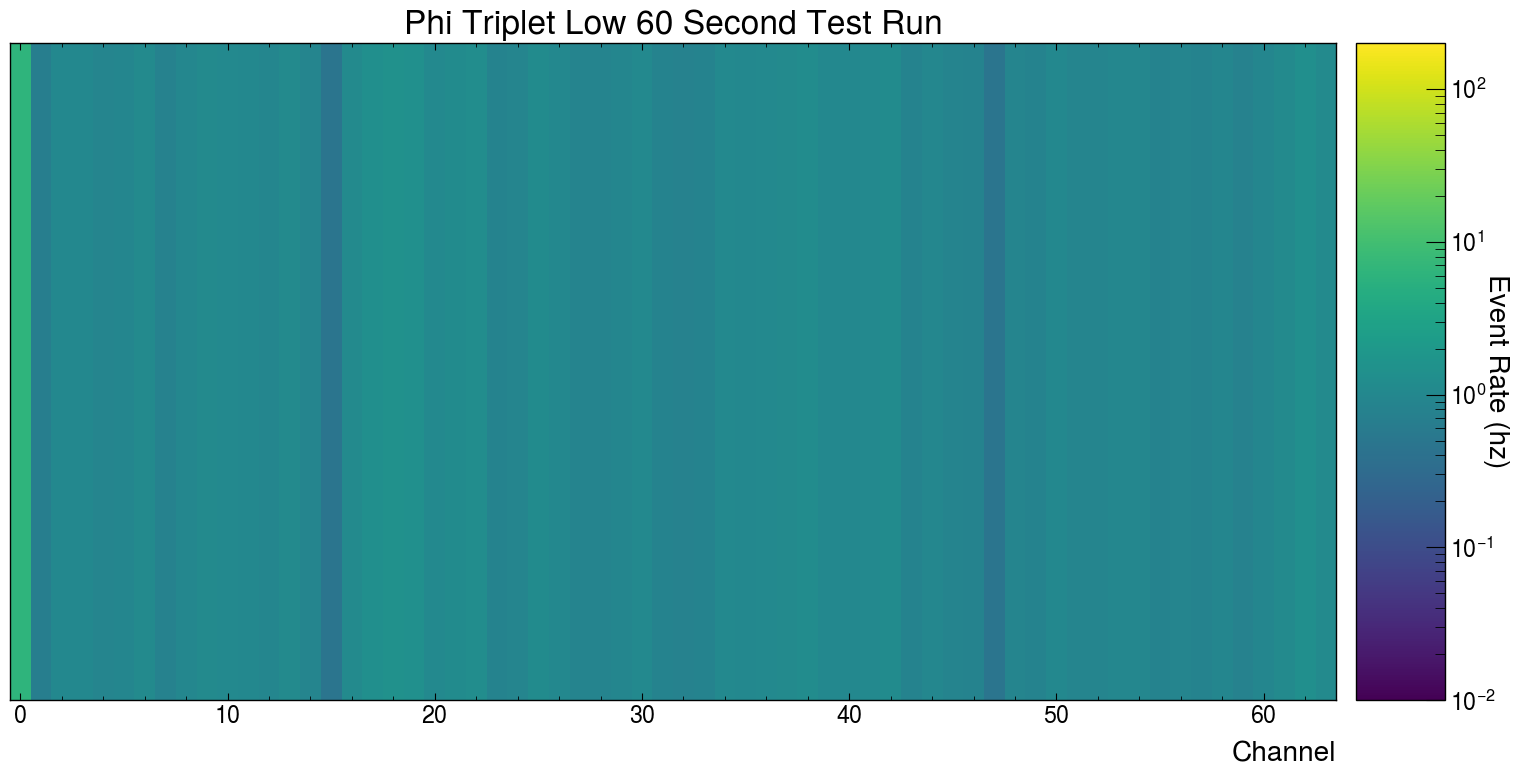

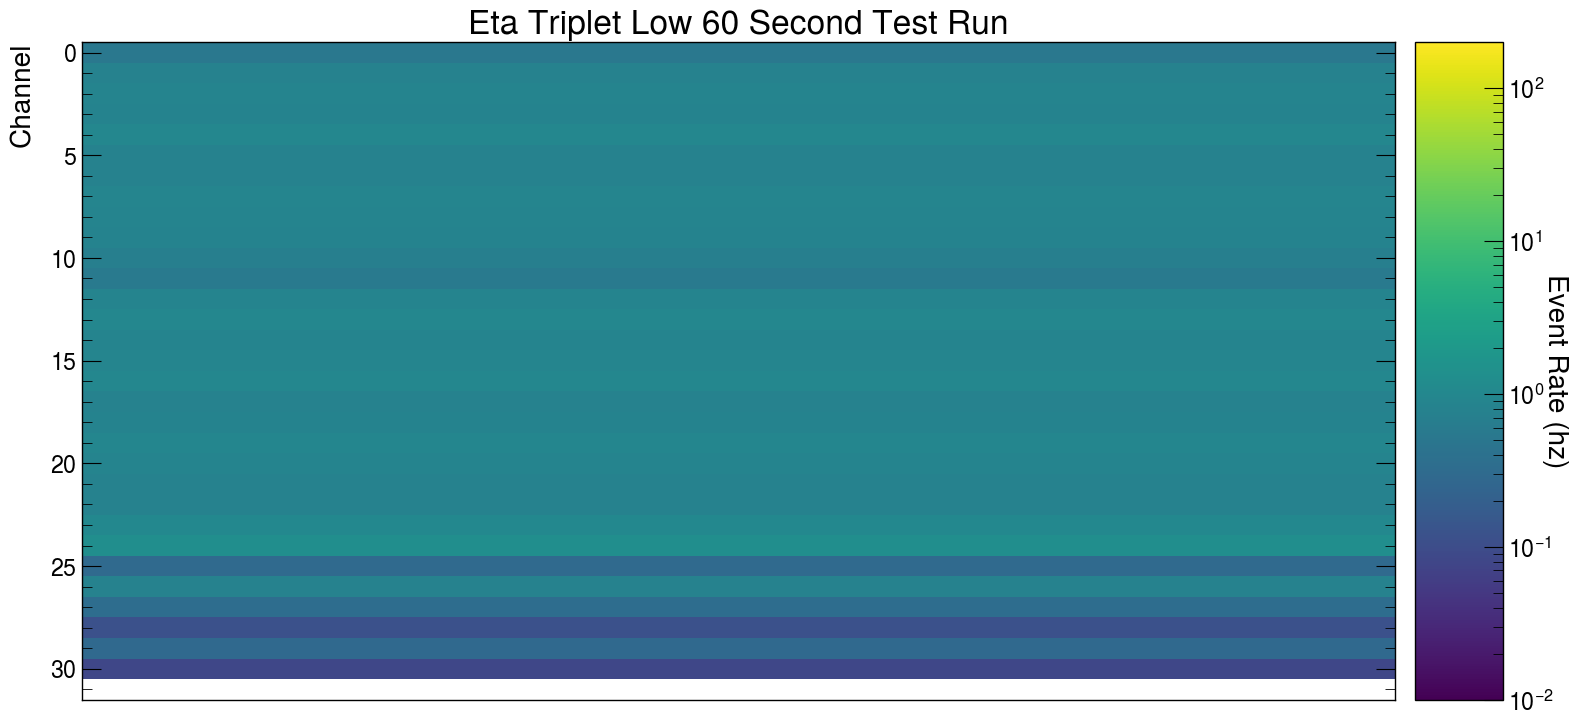

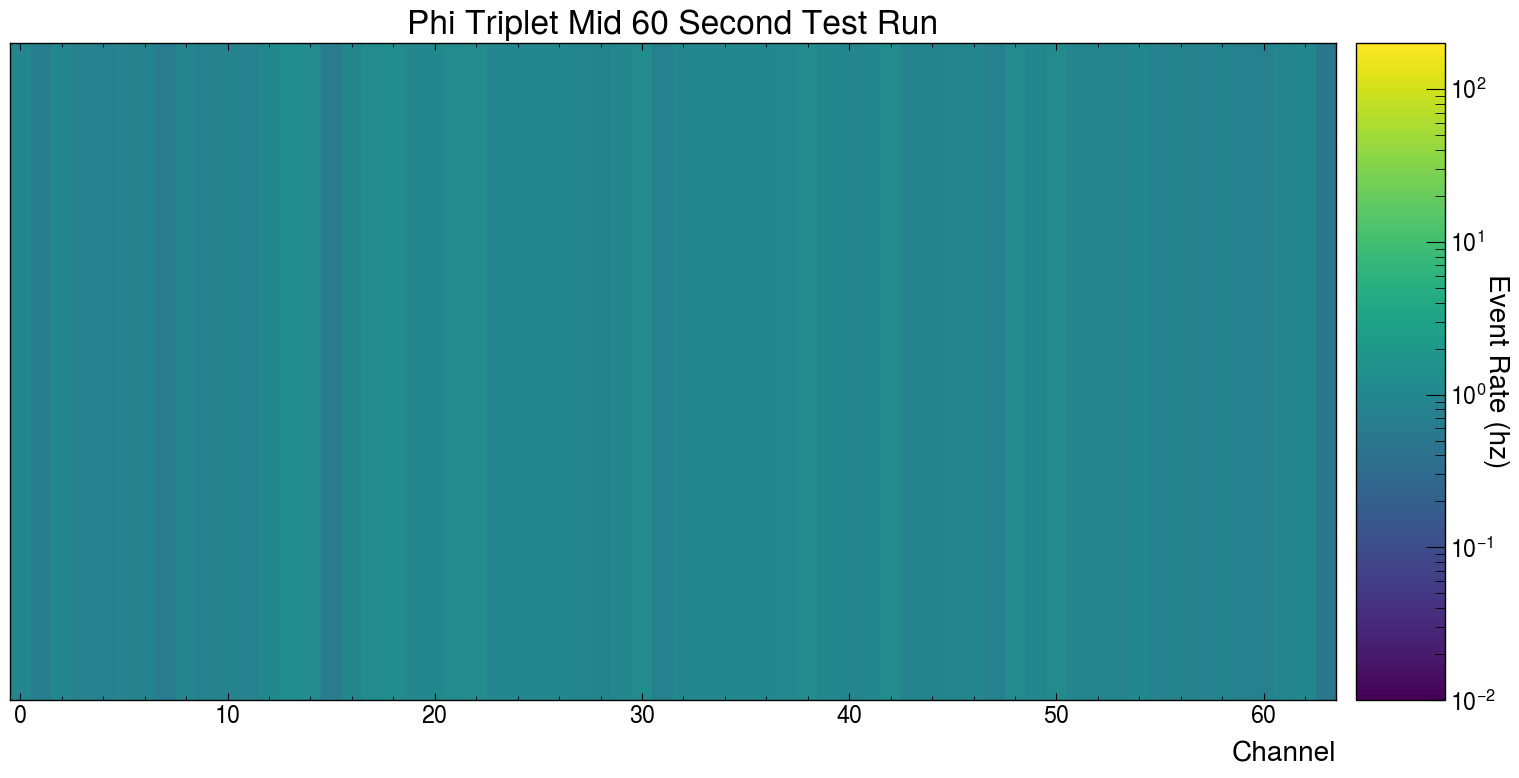

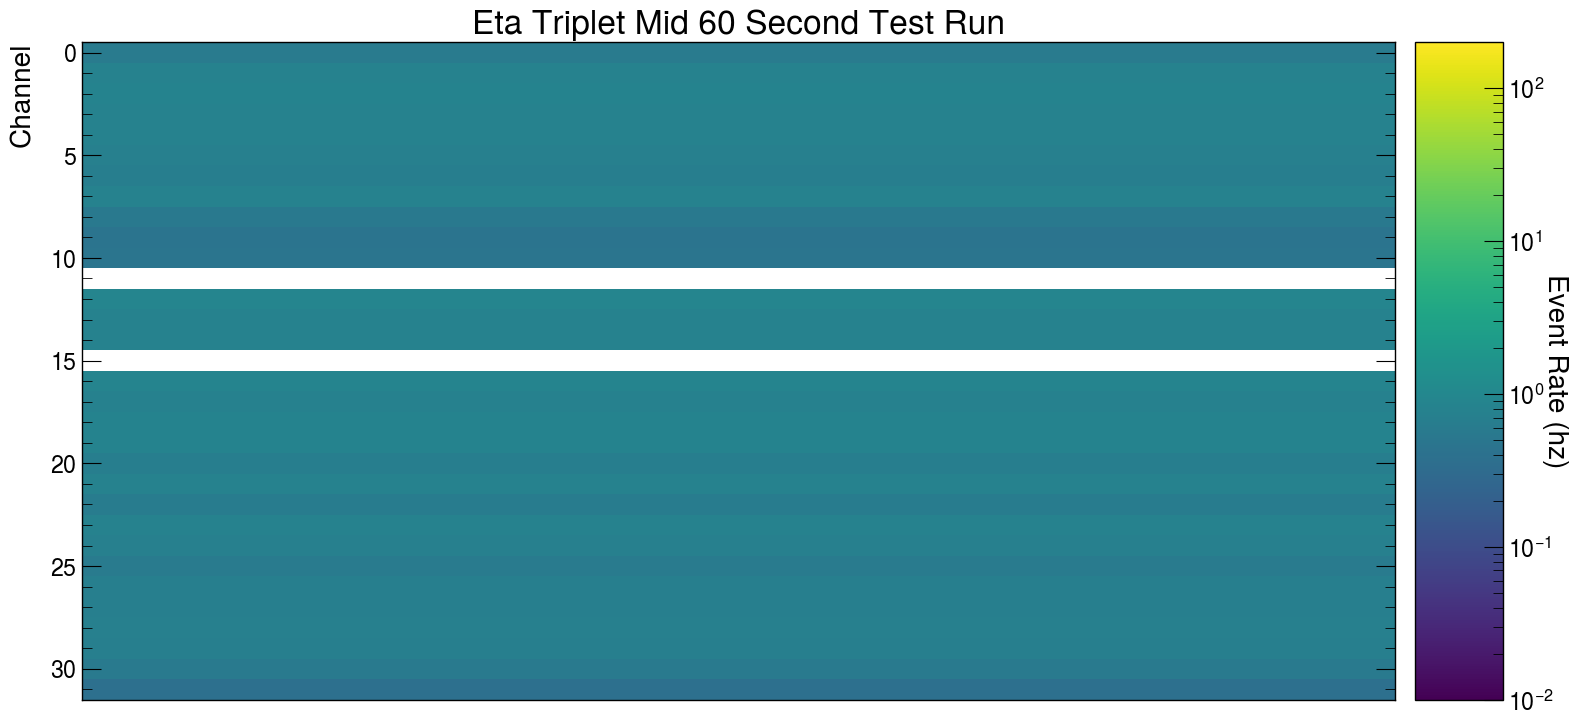

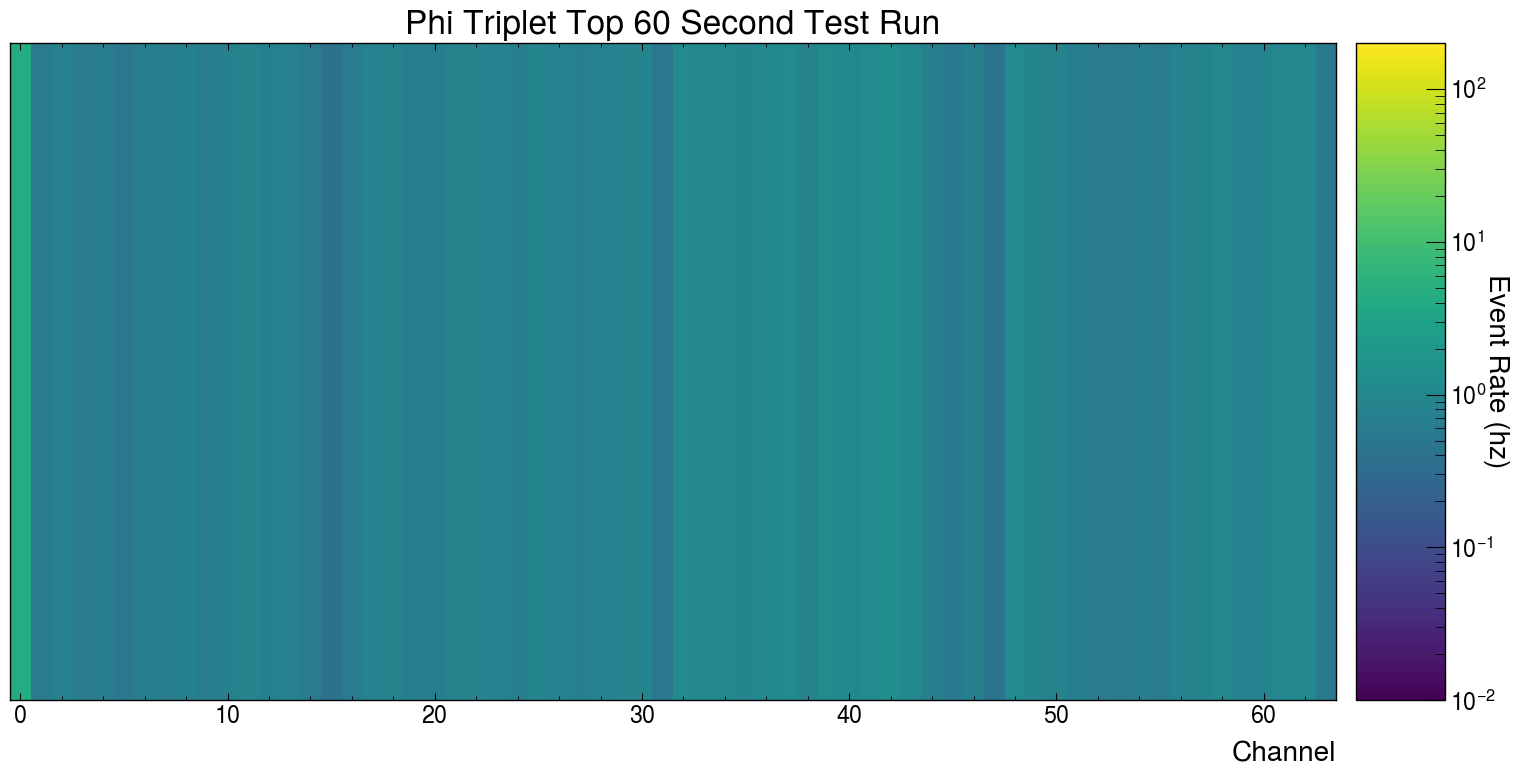

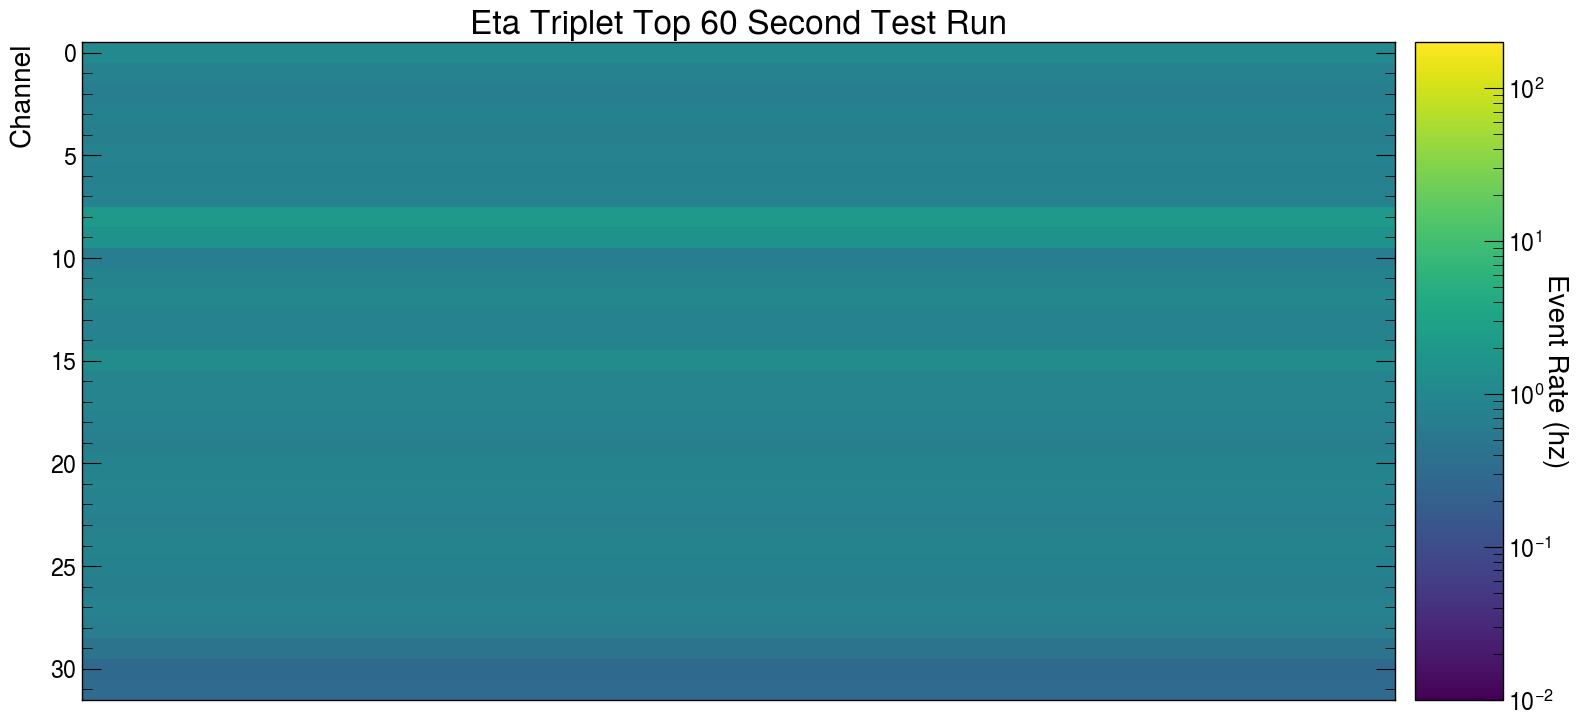

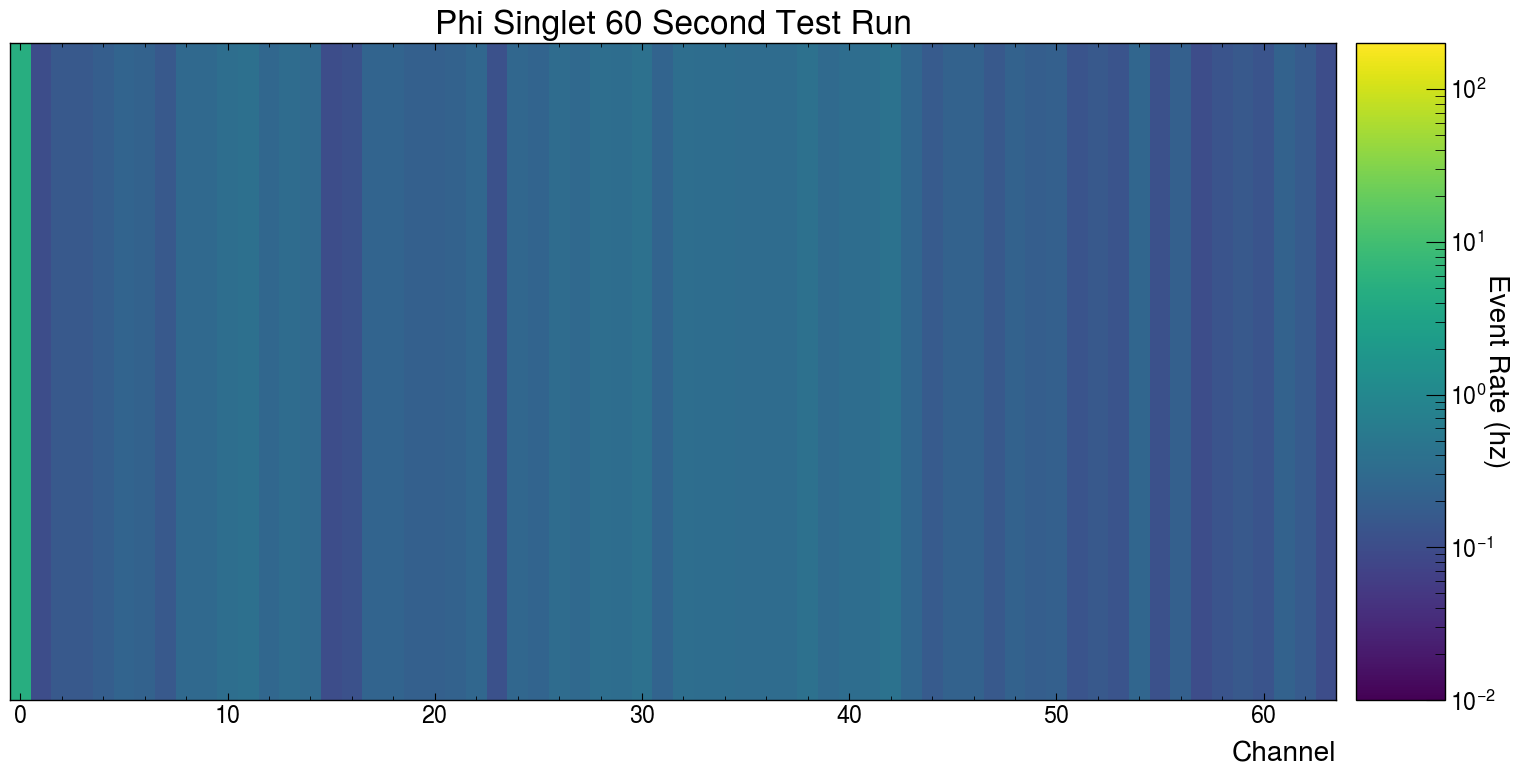

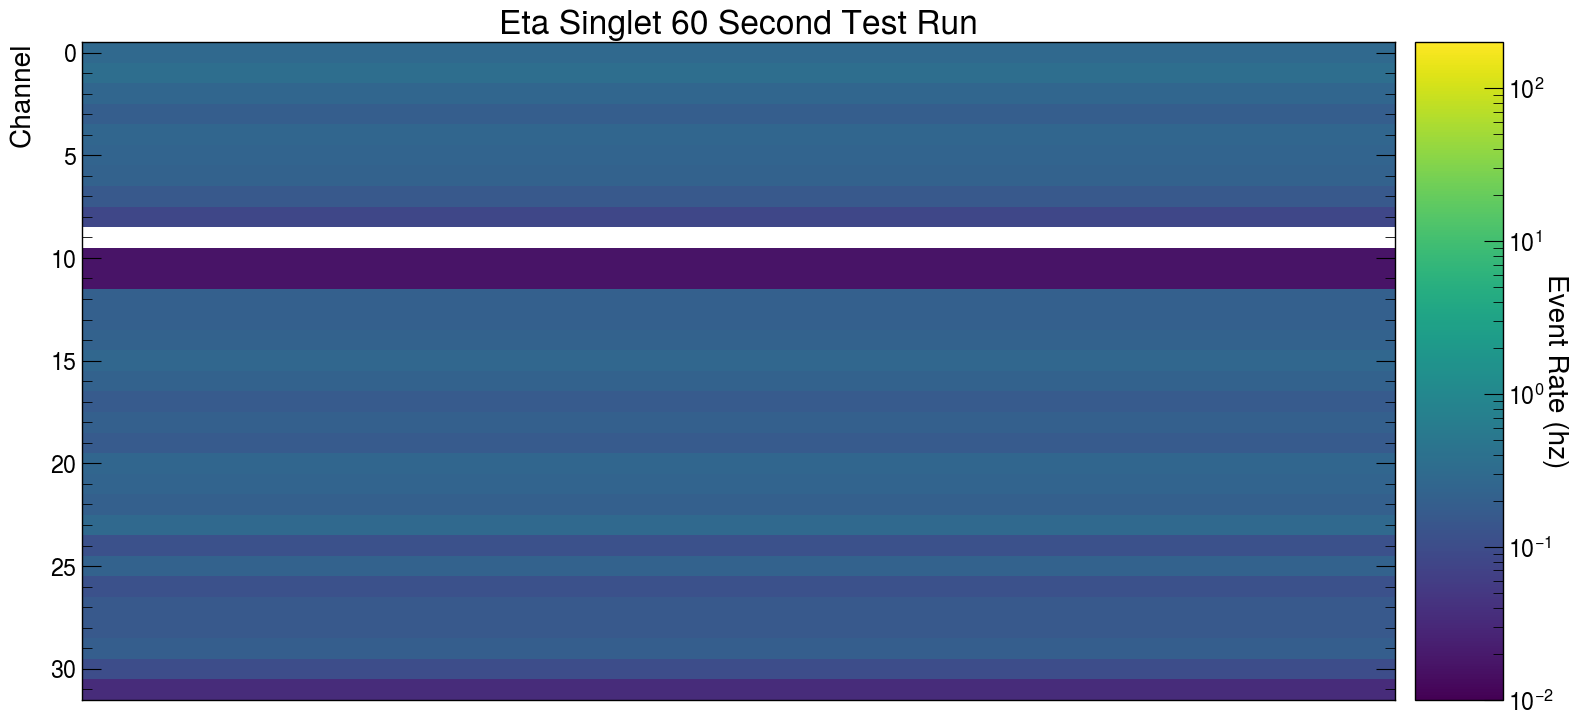

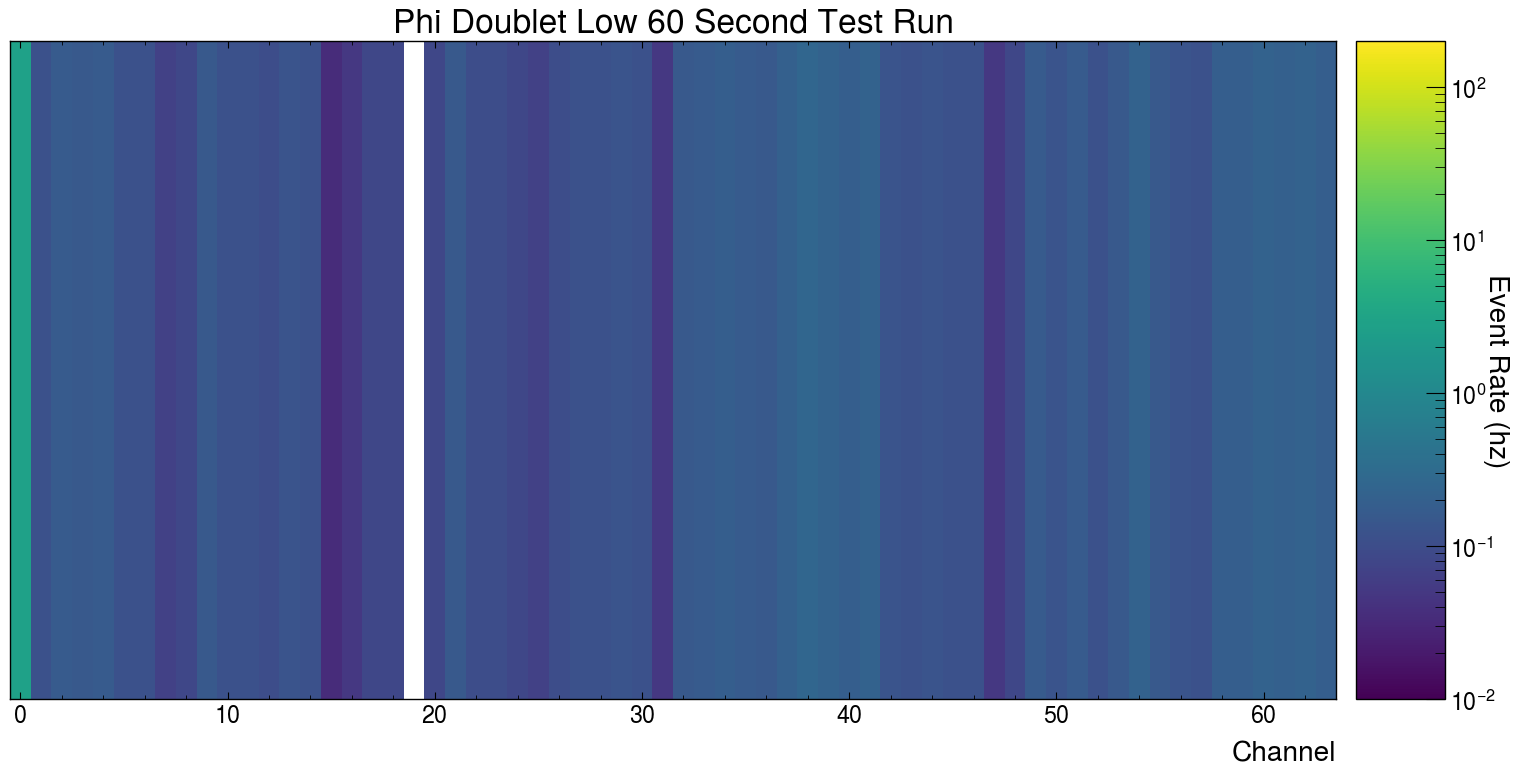

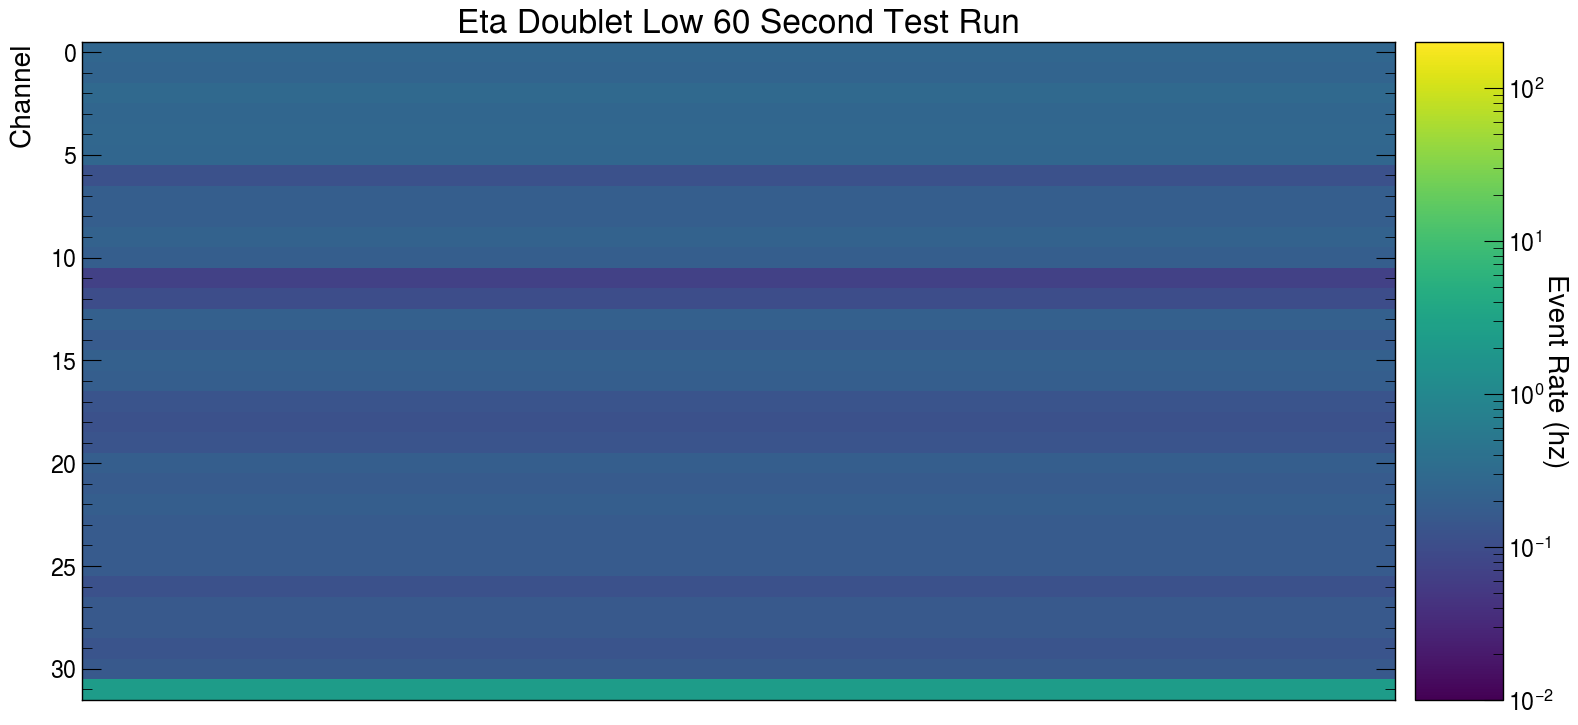

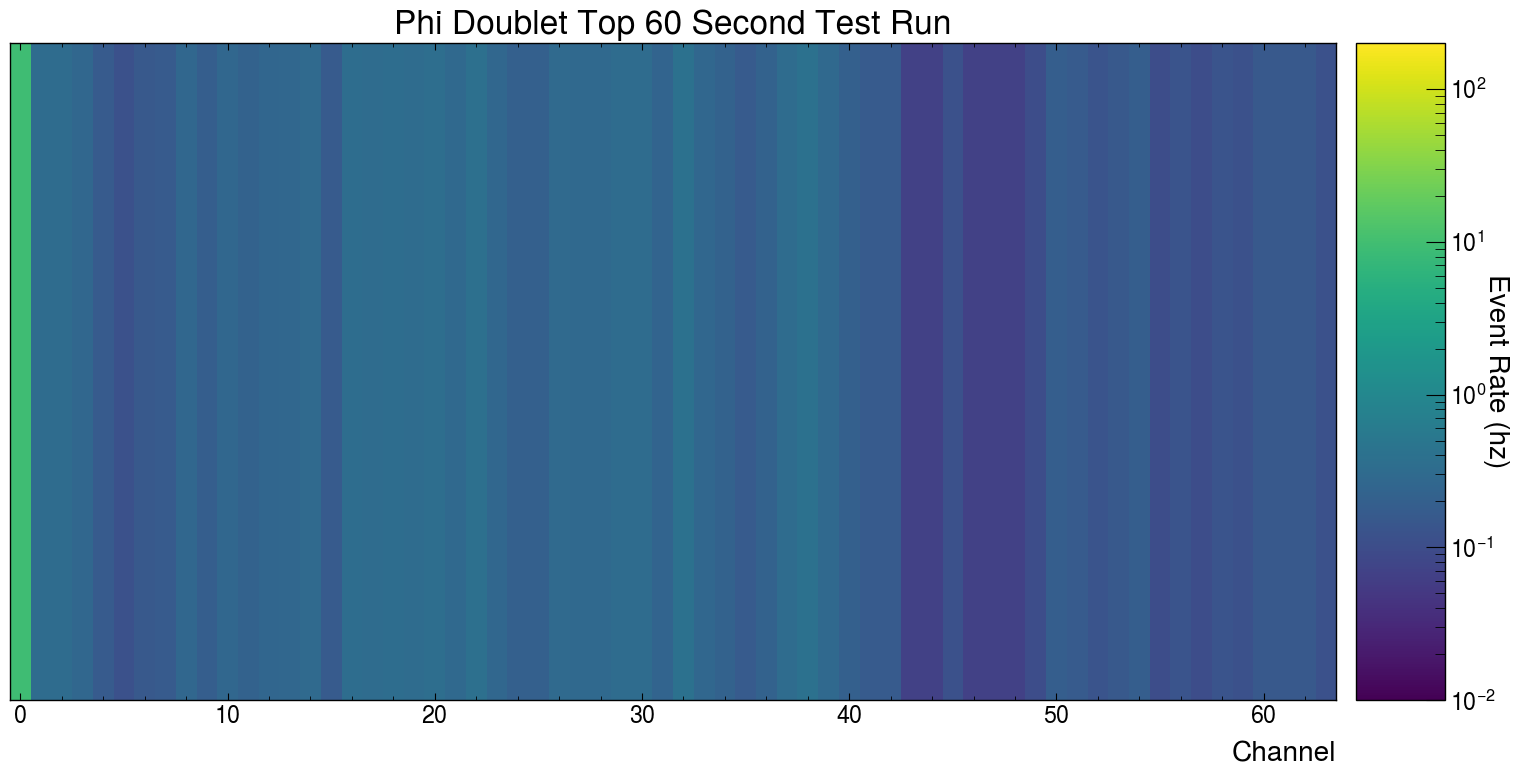

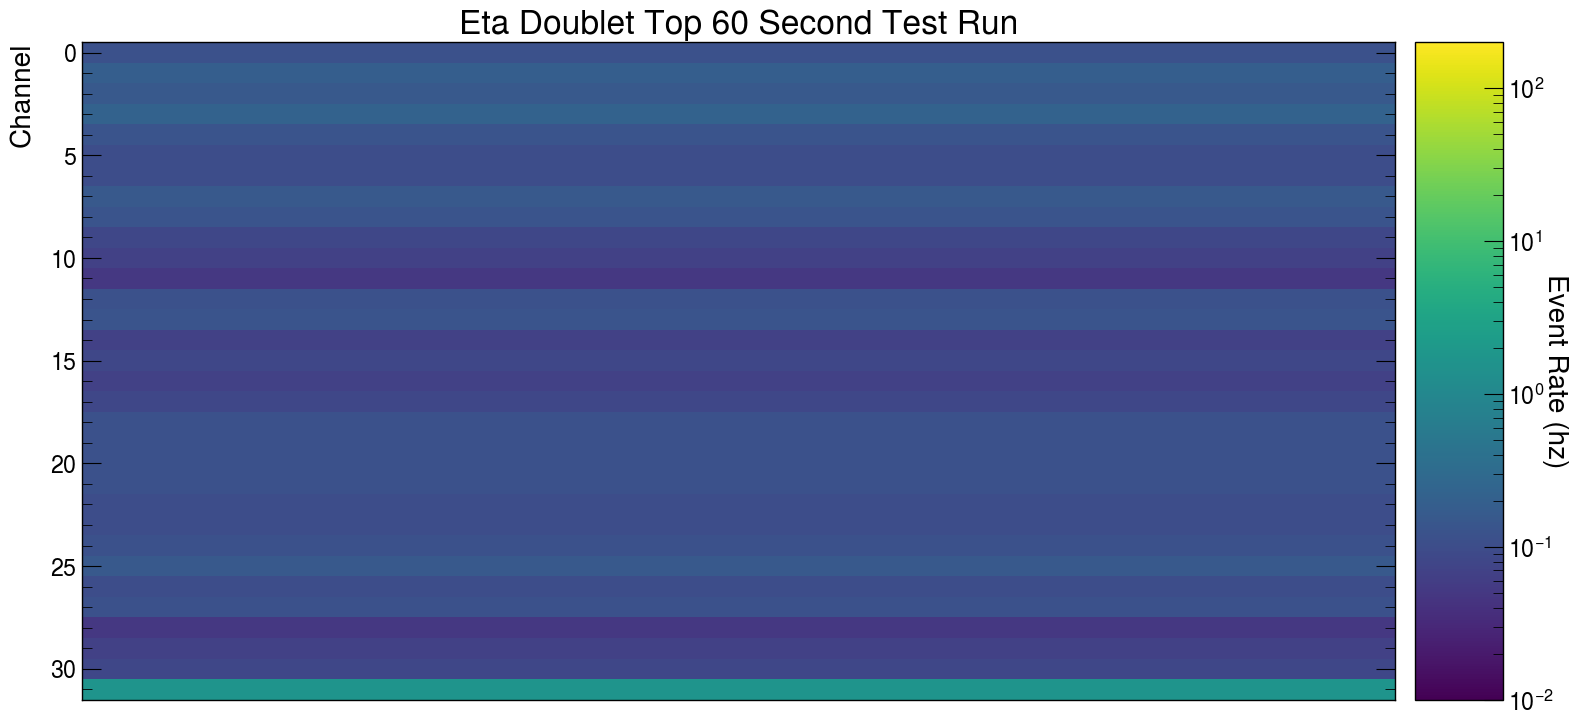

In [14]:
heatFromFile(current_directory+"\\ProAnubisData\\60sRun_24_3_4.h5",60,"60 Second Test Run")

In [18]:
def plotHitCounts(histogram, name):
    #Plot the number of hits per event to determine the mean hits within any given TDC, as well as see the long tails from correlated noise
    fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)
    # lab = hep.atlas.label(com=False,data=True, label="Internal")
    # lab[2].set_text(" ")
    hep.histplot(np.histogram(histogram,bins=[x-0.5 for x in range(140)]), label='TDC 0')
    plt.xlabel('TDC Hits')
    plt.ylabel('Events')
    plt.title(name)
    plt.xlim([-0.4,40.5])
    #plt.ylim([1,3000])
    plt.yscale('log')
    plt.savefig(name.strip(" ")+"chanCounts.png")
    return name.strip(" ")+"chanCounts.png"

In [19]:
def plotEventTimes(inputData, name):
    fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)
    # lab = hep.atlas.label(com=False,data=True, label="Internal")
    # lab[2].set_text(" ")
    hep.histplot(np.histogram(inputData,bins=[x-0.5 for x in range(1000)]), label='TDC 0')
    plt.xlabel('TDC Hit Times')
    plt.ylabel('Hits')
    plt.title(name)
    #plt.xlim([-0.4,40.5])
    #plt.ylim([1,3000])
    plt.yscale('log')
    plt.savefig(name.strip(" ")+"hitTimes.png")
    return name.strip(" ")+"hitTimes.png"

In [20]:
def divideHitCountsByRPC(data):
    #Divides the number of hits in each channel into individual RPCs
    etaHits = [[],[],[],[],[],[]]
    phiHits = [[],[],[],[],[],[]]
    for event in range(0,len(data[0])):
        tdcCounts = [countChannels([data[tdc][event]]) for tdc in range(5)]
        etaHits[0].append(tdcCounts[0][0:32]) #Triplet Eta Low
        phiHits[0].append(tdcCounts[0][32:96]) #Triplet Phi low
        etaHits[1].append(tdcCounts[0][96:128]) #Triplet Eta Mid
        phiHits[1].append(tdcCounts[1][0:64]) #Triplet Phi Mid
        etaHits[2].append(tdcCounts[1][64:96]) #Triplet Eta Top
        phiHits[2].append(tdcCounts[1][96:128]+tdcCounts[2][0:32]) #Triplet Phi Top
        etaHits[3].append(tdcCounts[2][32:64])#Singlet Eta
        phiHits[3].append(tdcCounts[2][64:128])#Singlet Phi
        etaHits[4].append(tdcCounts[3][0:32])#Double Eta low
        phiHits[4].append(tdcCounts[3][32:96])#Double Phi Low
        etaHits[5].append(tdcCounts[3][96:128])#Doublet Eta top
        phiHits[5].append(tdcCounts[4][0:64])#Doublet Phi top
    return etaHits,phiHits

In [21]:
data = importDatafile(current_directory+"\\ProAnubisData\\threeHourRun_24_3_1.h5")
etaHits, phiHits = divideHitCountsByRPC(data)

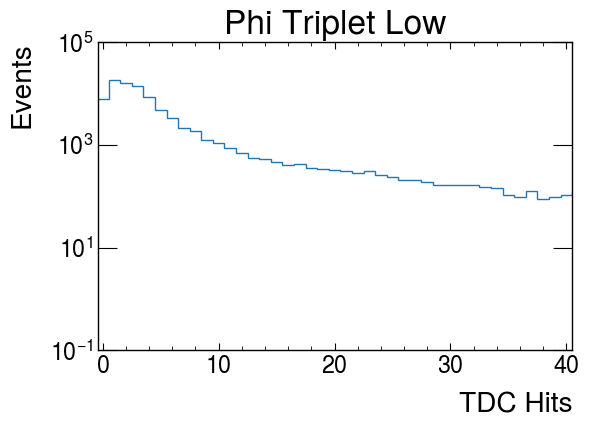

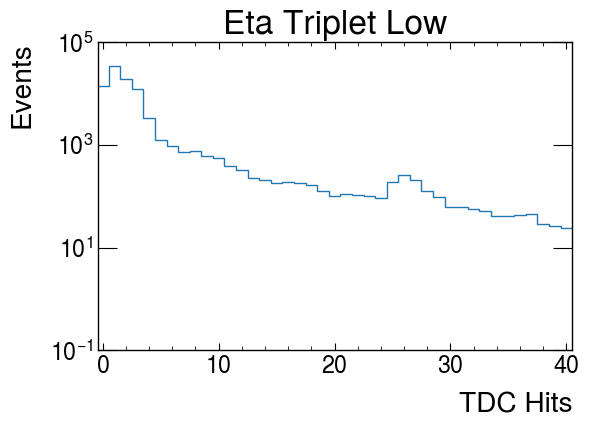

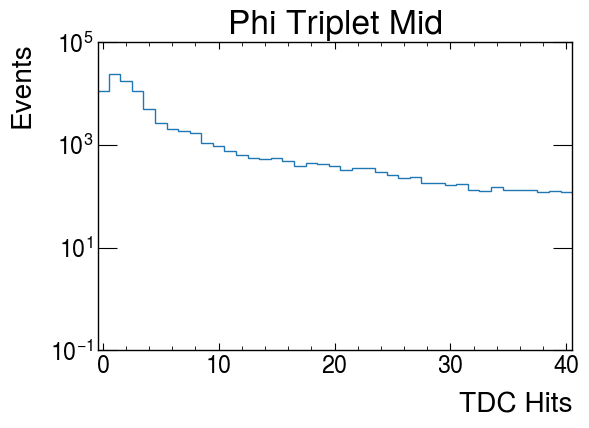

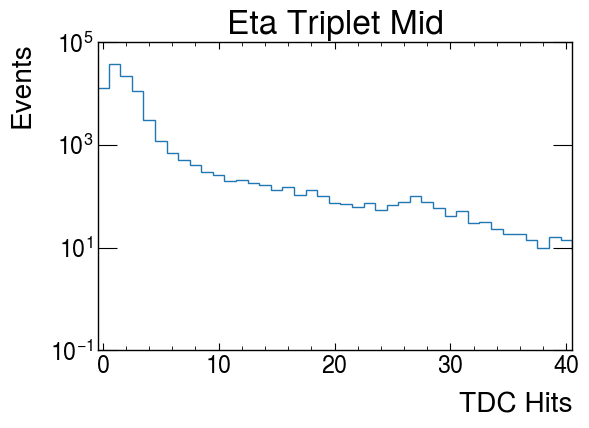

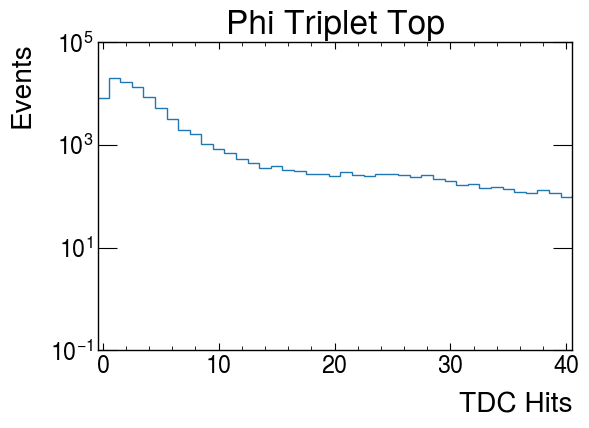

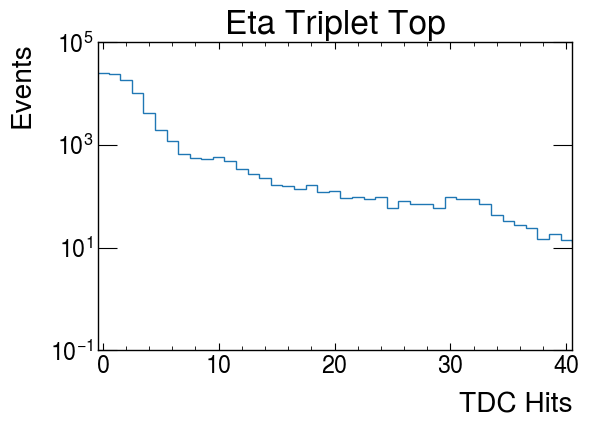

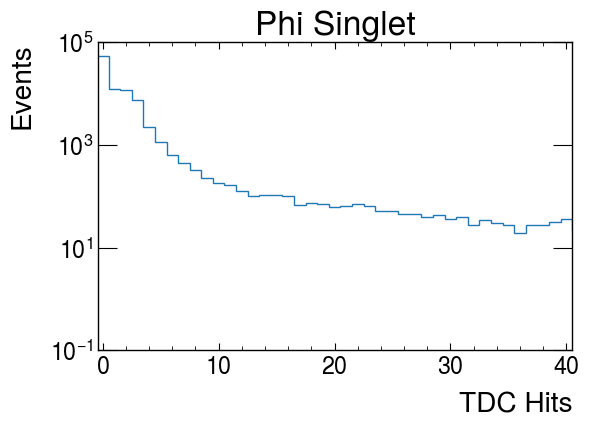

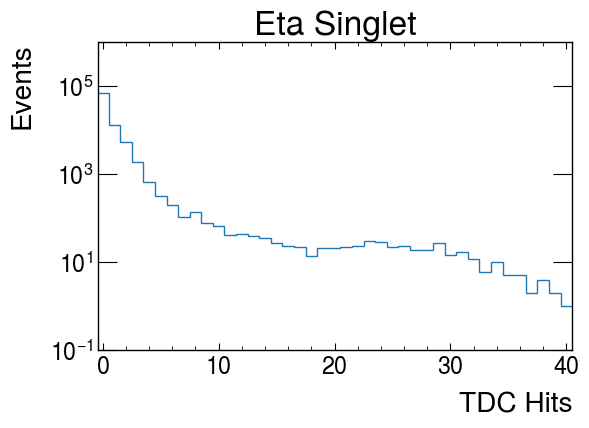

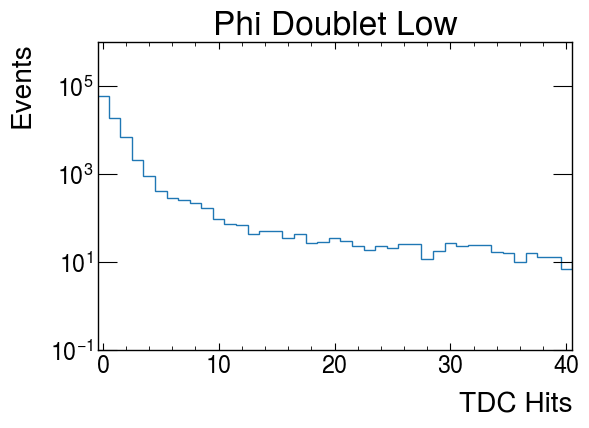

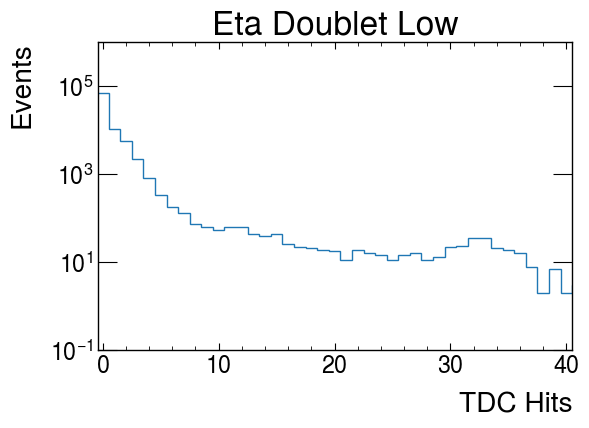

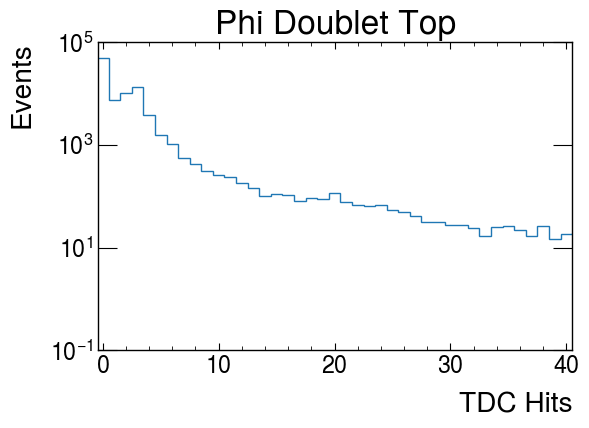

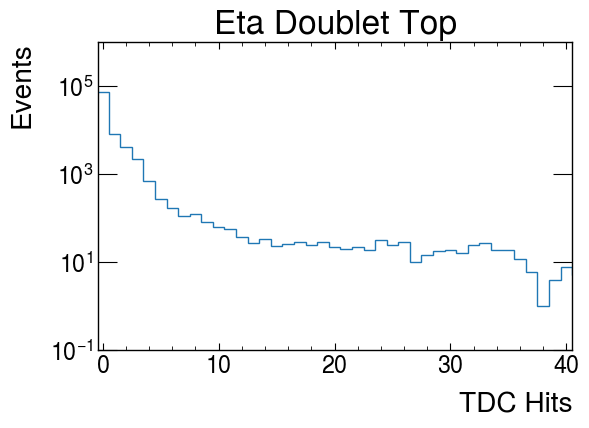

In [33]:
etaLayerNames = ["Eta Triplet Low","Eta Triplet Mid", "Eta Triplet Top", "Eta Singlet","Eta Doublet Low", "Eta Doublet Top"]
phiLayerNames = ["Phi Triplet Low","Phi Triplet Mid", "Phi Triplet Top", "Phi Singlet","Phi Doublet Low", "Phi Doublet Top"]
hitCountNames = []
for idx, layer in enumerate(etaHits):
    etaSums = []
    phiSums = []
    for event in layer:
        etaSums.append(sum(event))
    for event in phiHits[idx]:
        phiSums.append(sum(event))
    hitCountNames.append(plotHitCounts(phiSums,phiLayerNames[idx]))
    hitCountNames.append(plotHitCounts(etaSums,etaLayerNames[idx]))
anPlot.combinePlots(hitCountNames,"3HourRPCHitCounts")
for name in hitCountNames:
    os.remove(name)

In [14]:
def divideEventsByRPC_OLD(data):
    #Divides the data into individual RPCs, preserving the initial words within each event
    splitEvents = []
    for event in range(len(data[0])):
        thisEvent = [[] for rpc in range(12)]
        for tdc in range(5):
            for word in data[tdc][event]:
                chan = word>>24
                if(tdc==0):
                    if(chan<32):
                        #Triplet Eta Low
                        thisEvent[0].append(word)
                    elif(chan<96):
                        #Triplet Phi Low
                        thisEvent[1].append(word)
                    else:
                        #Triplet Eta Mid
                        thisEvent[2].append(word)
                elif(tdc==1):
                    if(chan<64):
                        #Triplet Phi Mid
                        thisEvent[3].append(word)
                    elif(chan<96):
                        #Triplet Eta Top
                        thisEvent[4].append(word)
                    else:
                        #Triplet Phi 1 Top
                        thisEvent[5].append(word)
                elif(tdc==2):
                    if(chan<32):
                        #Triplet Phi 2 Top, this seems wrong too. This should be stored in index 5 not 6.
                        thisEvent[6].append(word)
                    elif(chan<64):
                        #Singlet Eta
                        thisEvent[7].append(word)
                    else:
                        #Singlet Phi
                        thisEvent[8].append(word)   
                elif(tdc==3):
                    if(chan<32):
                        #Doublet Eta Low This seems wrong, why are we currently storing Doublet Eta Low and Singlet Phi in the same index 8?
                        thisEvent[8].append(word)
                    elif(chan<64):
                        #Doublet Phi Low, This seems wrong, Doublet Phi low spans to 96 channel.
                        thisEvent[9].append(word)
                    else:
                        thisEvent[10].append(word)                
                elif(tdc==4):
                    #Doublet Phi Top
                    thisEvent[11].append(word)
        splitEvents.append(thisEvent)
    return splitEvents

In [15]:
def divideEventsByRPC(data):
    #Divides the data into individual RPCs, preserving the initial words within each event
    splitEvents = []
    for event in range(len(data[0])):
        thisEvent = [[] for rpc in range(12)]
        for tdc in range(5):
            for word in data[tdc][event]:
                chan = word>>24
                if(tdc==0):
                    if(chan<32):
                        #Triplet Eta Low
                        thisEvent[0].append(word)
                    elif(chan<96):
                        #Triplet Phi Low
                        thisEvent[1].append(word)
                    else:
                        #Triplet Eta Mid
                        thisEvent[2].append(word)
                elif(tdc==1):
                    if(chan<64):
                        #Triplet Phi Mid
                        thisEvent[3].append(word)
                    elif(chan<96):
                        #Triplet Eta Top
                        thisEvent[4].append(word)
                    else:
                        #Triplet Phi 1 Top
                        thisEvent[5].append(word)
                elif(tdc==2):
                    if(chan<32):
                        #Triplet Phi 2 Top, this seems wrong too. This should be stored in index 5 not 6. Relabelled to 5
                        thisEvent[5].append(word)
                    elif(chan<64):
                        #Singlet Eta, Relabelled from 7 to 6.
                        thisEvent[6].append(word)
                    else:
                        #Singlet Phi, Relabelled from 8 to 7
                        thisEvent[7].append(word)   
                elif(tdc==3):
                    if(chan<32):
                        #Doublet Eta Low This seems wrong, why are we currently storing Doublet Eta Low and Singlet Phi in the same index 8? Relabbeld Singlet Phi index, should be fixed.
                        thisEvent[8].append(word)
                    elif(chan<96):
                        #Doublet Phi Low, This seems wrong, Doublet Phi low spans to 96 channel. Changed from 64 to 96.
                        thisEvent[9].append(word)
                    else:
                        thisEvent[10].append(word)                
                elif(tdc==4):
                    #Doublet Phi Top
                    thisEvent[11].append(word)
        splitEvents.append(thisEvent)
    return splitEvents

In [16]:
def countCoincidences(primRpc,SecRpc, winSize=5, minHit=3, maxHit=10):
    #Count events where at least minHit channels have an RPC hit within winSize of each channel, while the primary and secondary RPC has more than minHit and less than maxHit to filter noise events
    #Uses the pre-made hit counts instead of the event words directly
    coincArray = [0 for channel in range(len(primRpc[0]))]
    for idx, event in enumerate(primRpc):
        for channel in range(len(event)):
            nHits = 0
            for itr in range(channel-int(winSize/2.), channel+int(winSize/2.)+1):
                if itr>=0 and itr<len(event):
                    if event[channel]>0:
                        nHits = nHits+1
            if nHits>=minHit and sum(event)<=maxHit:
                if sum(SecRpc[idx])>=minHit and sum(SecRpc[idx])<=maxHit:
                    coincArray[channel]=coincArray[channel]+1
    return coincArray

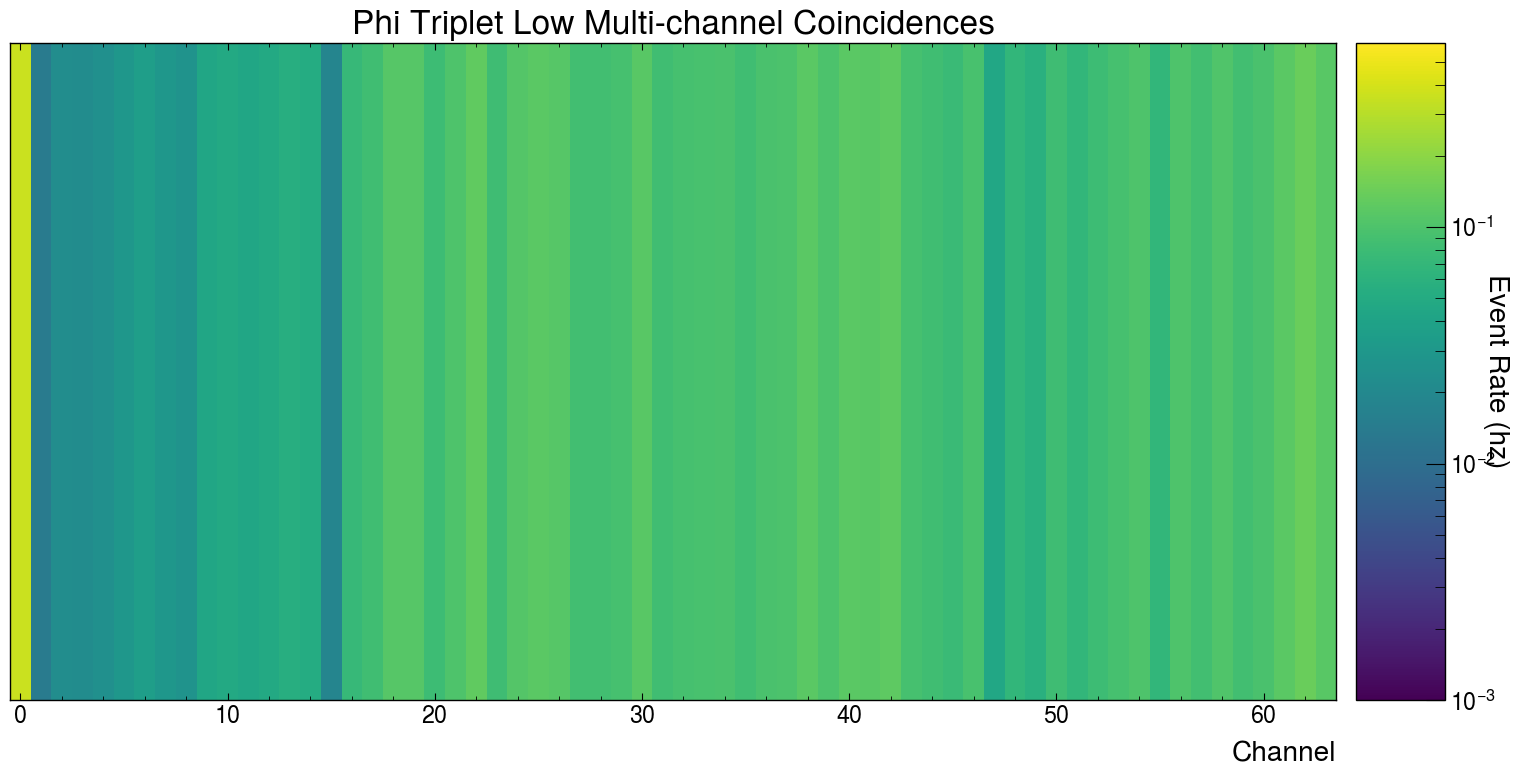

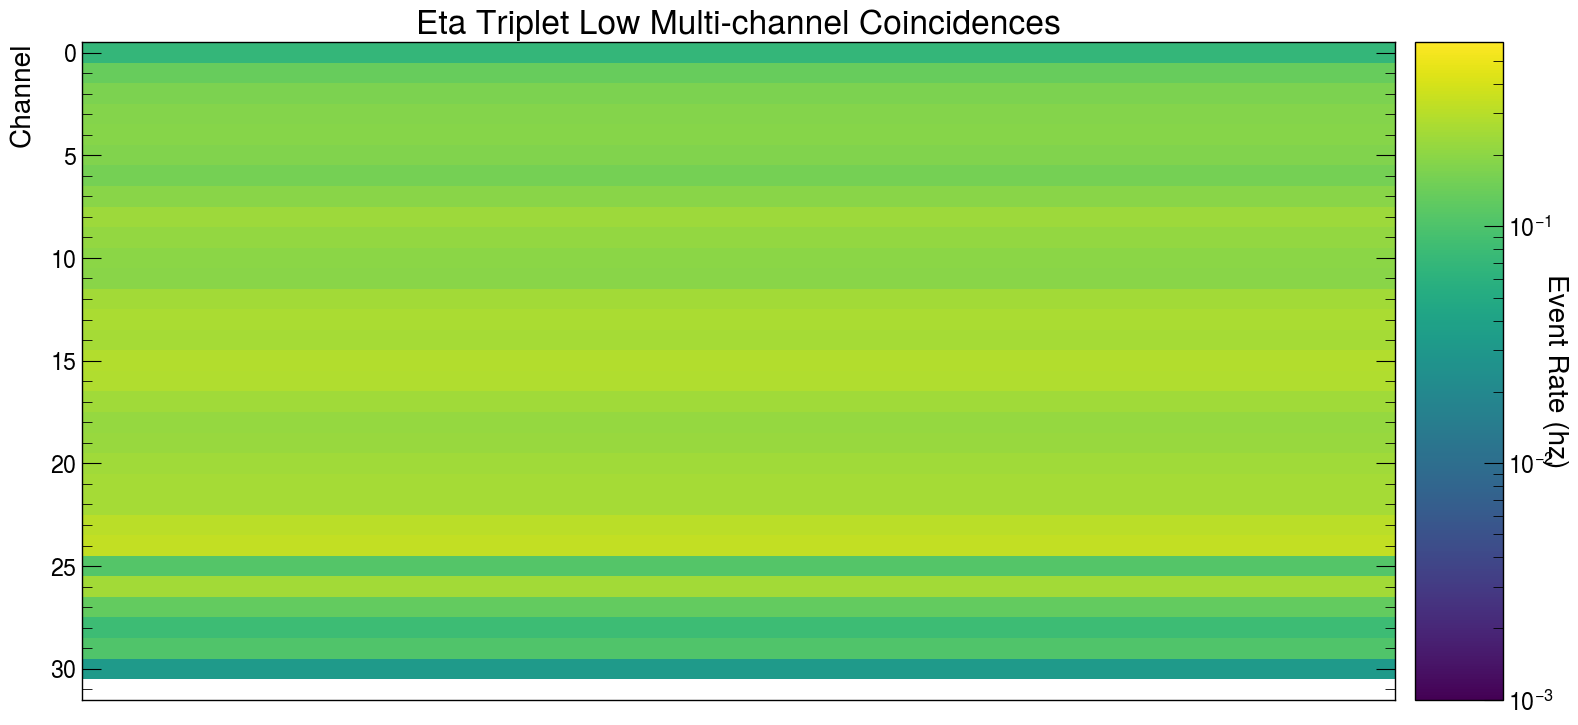

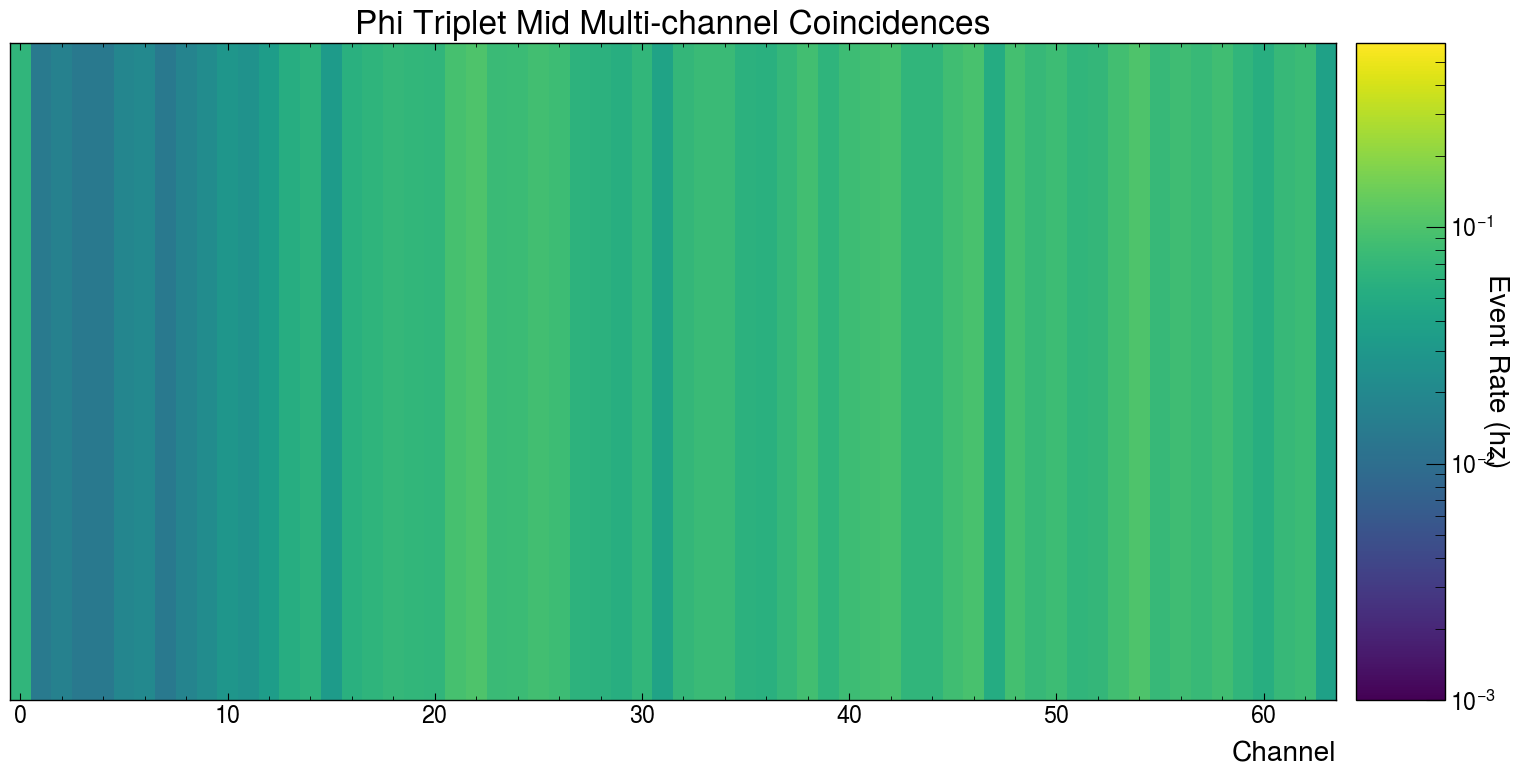

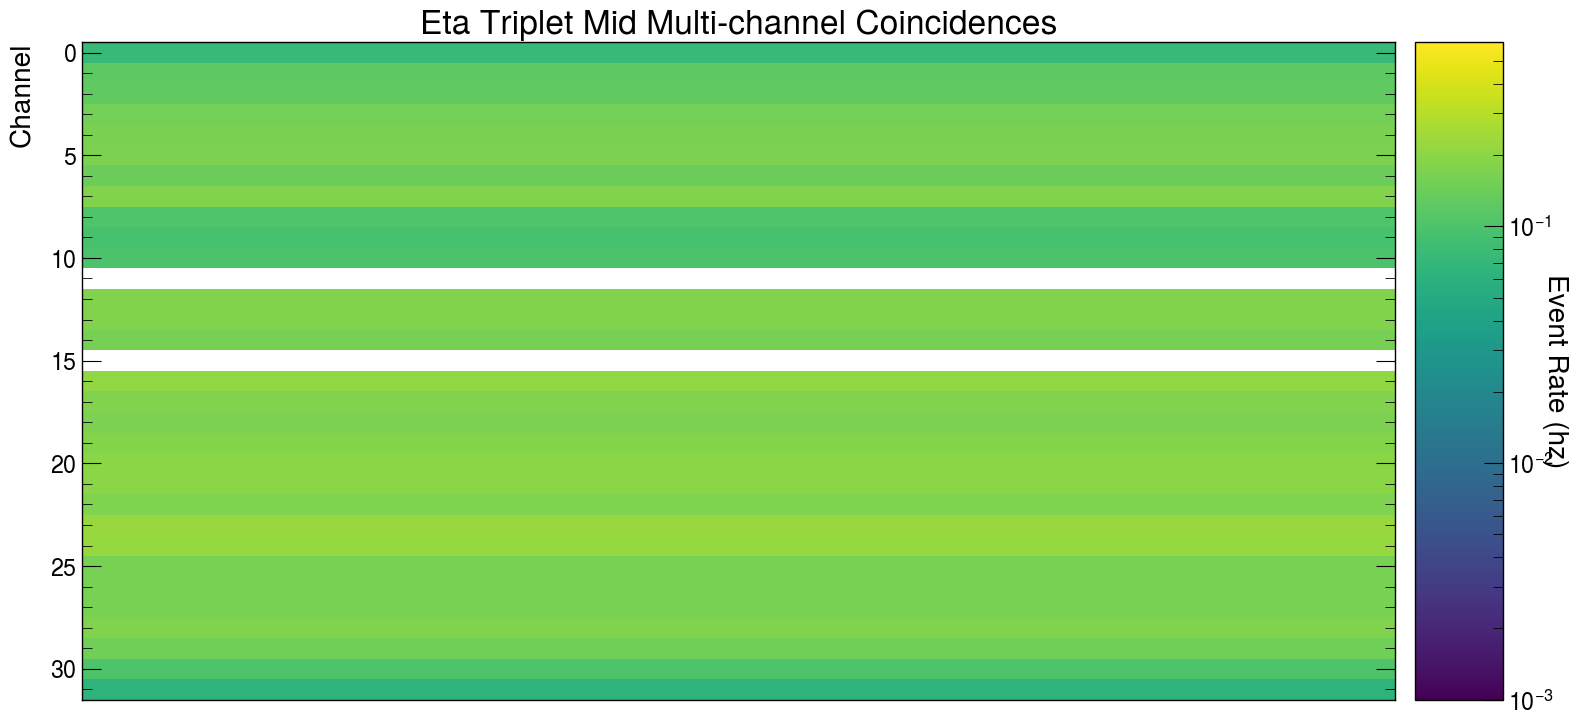

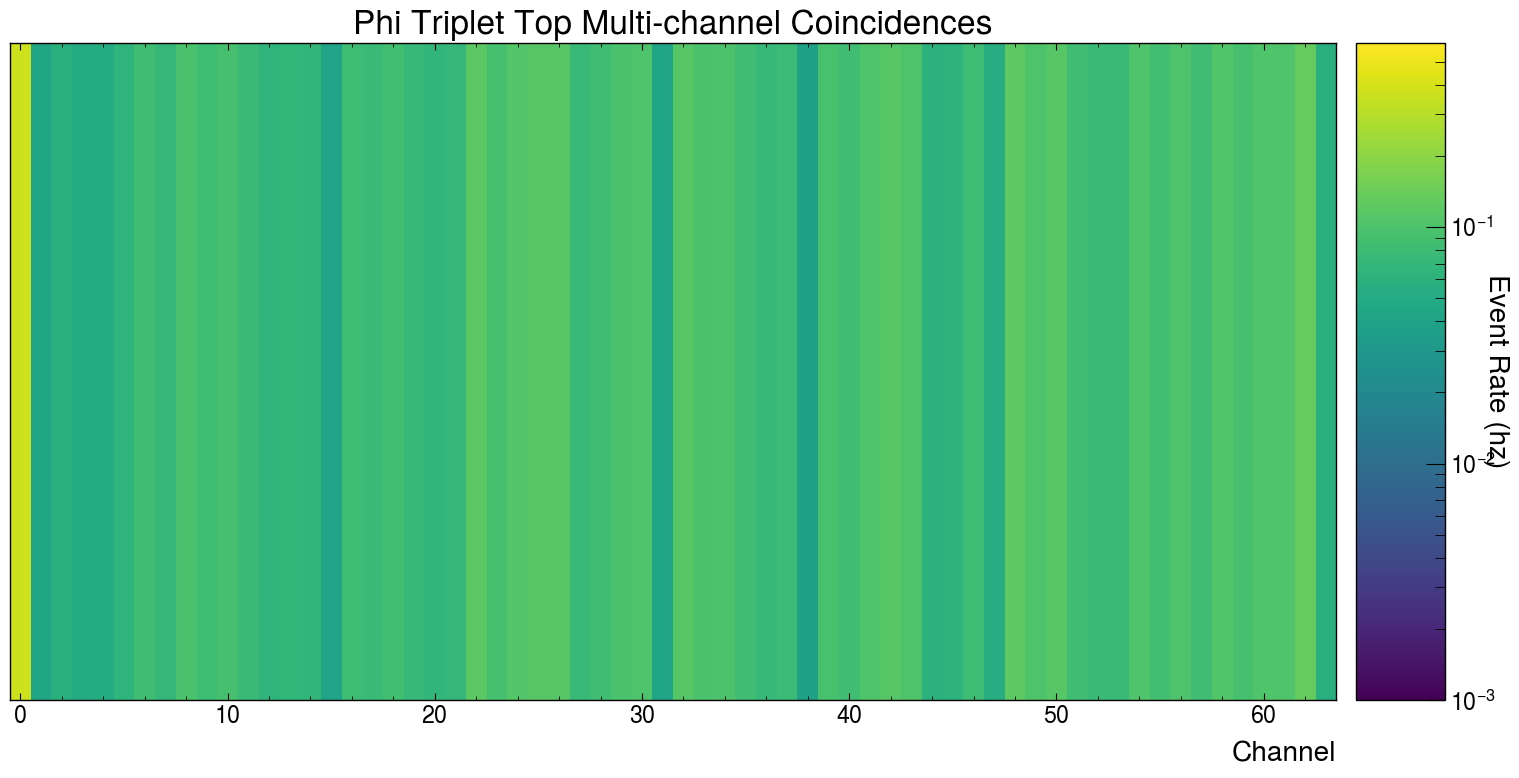

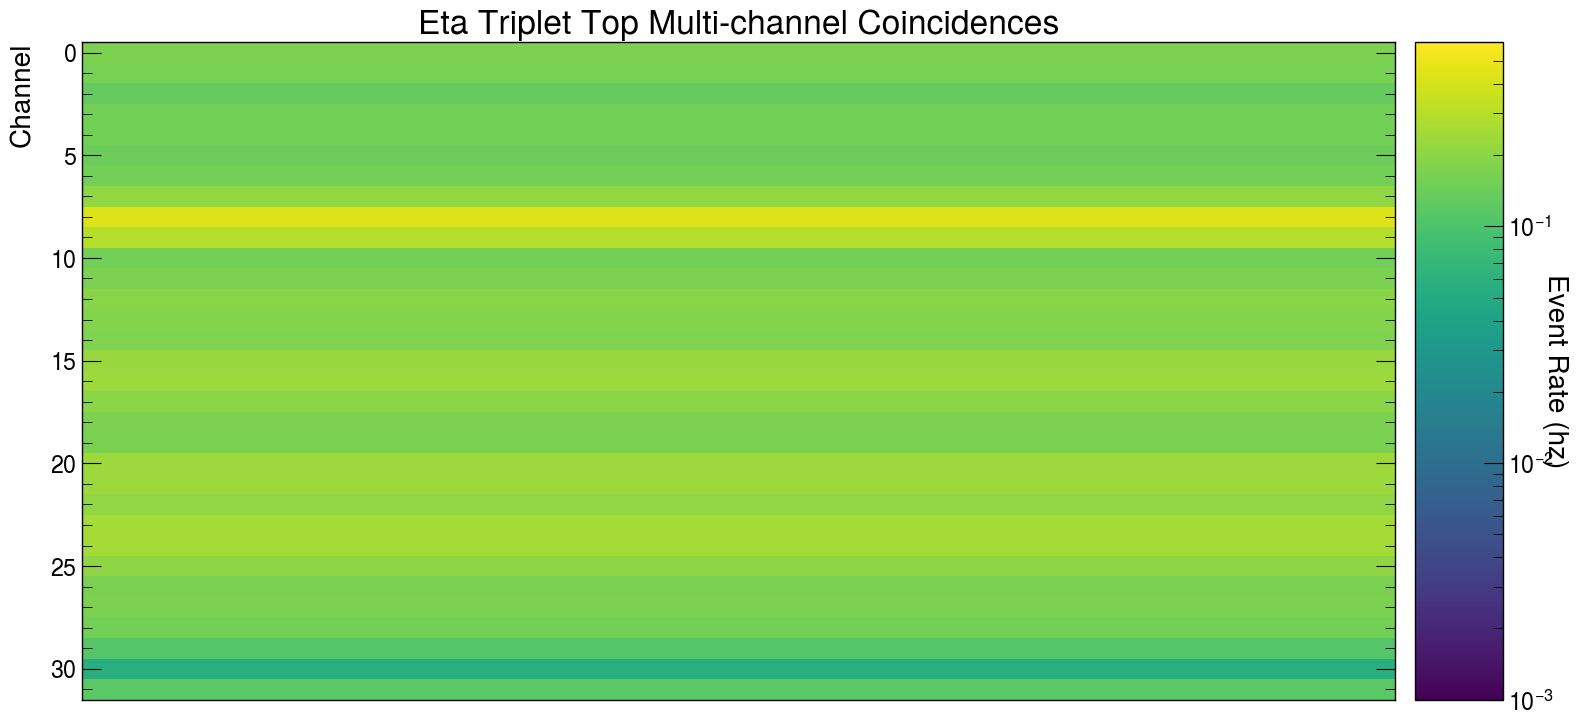

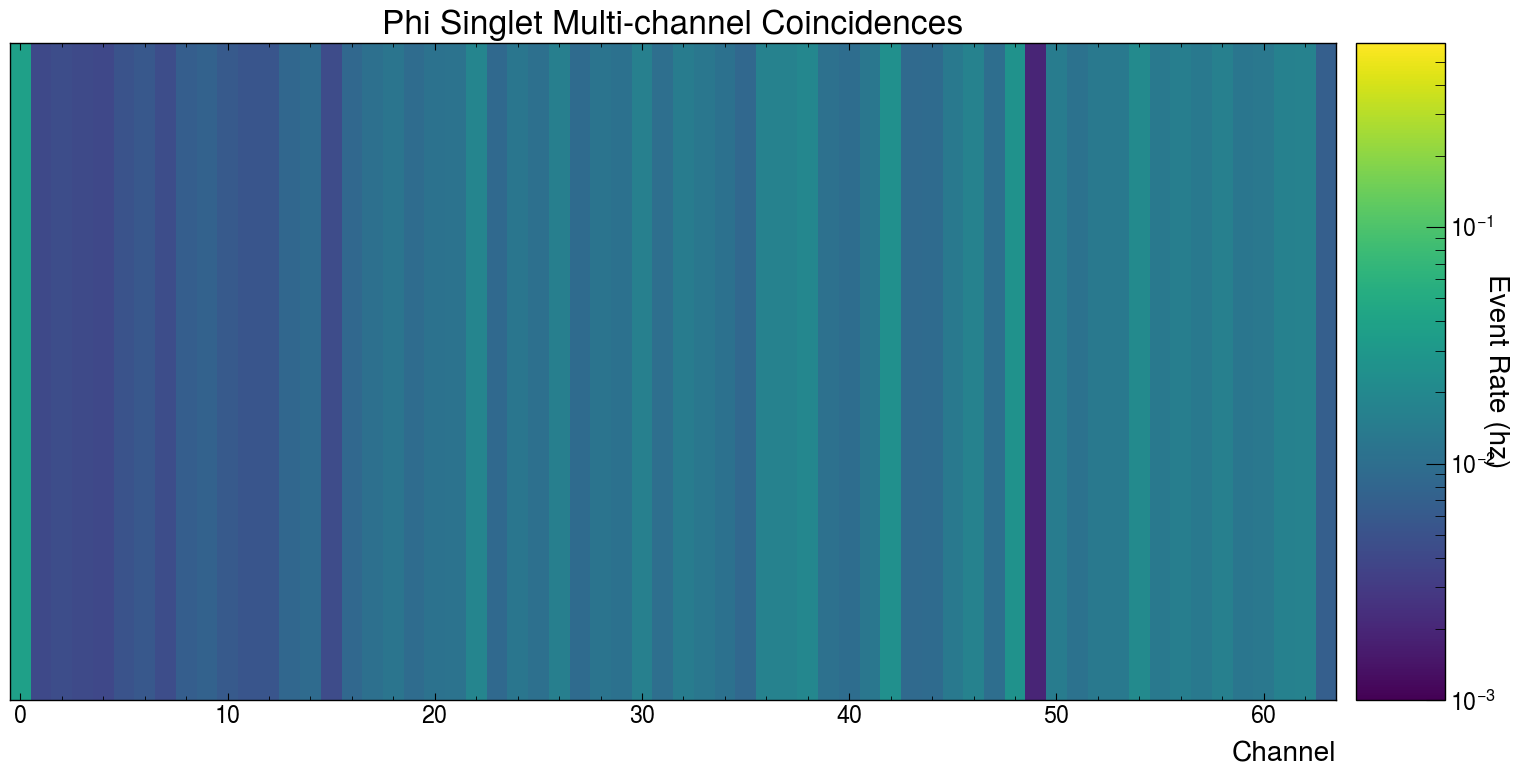

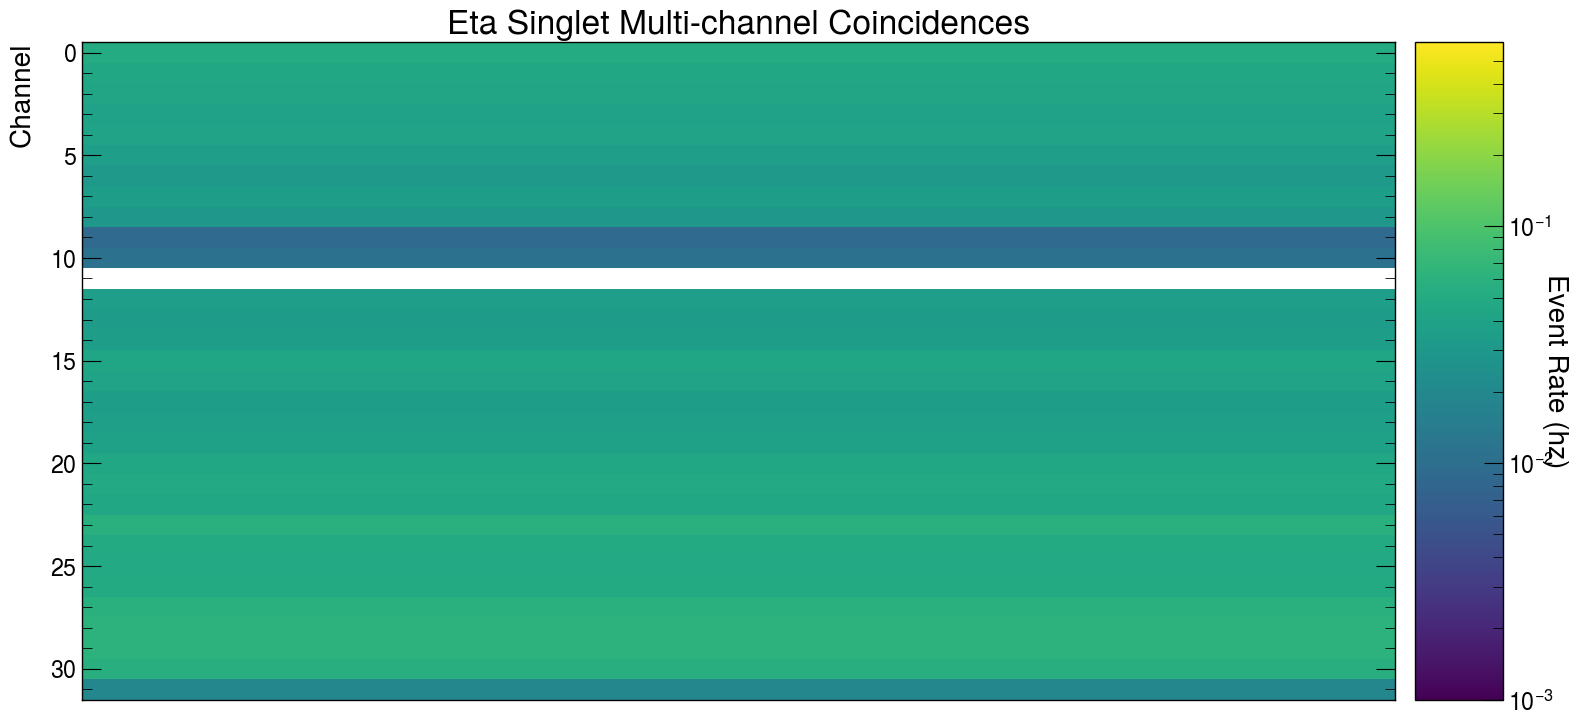

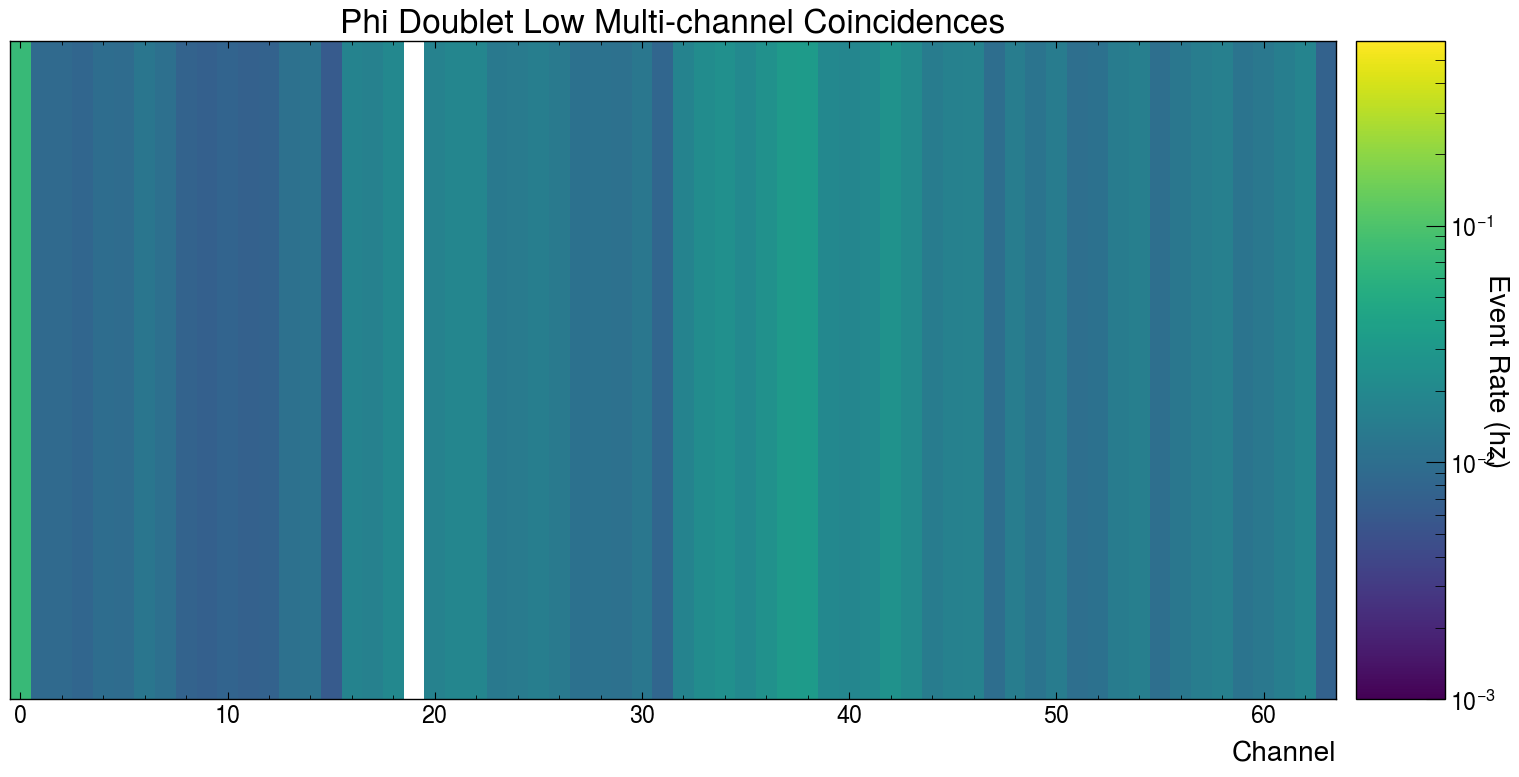

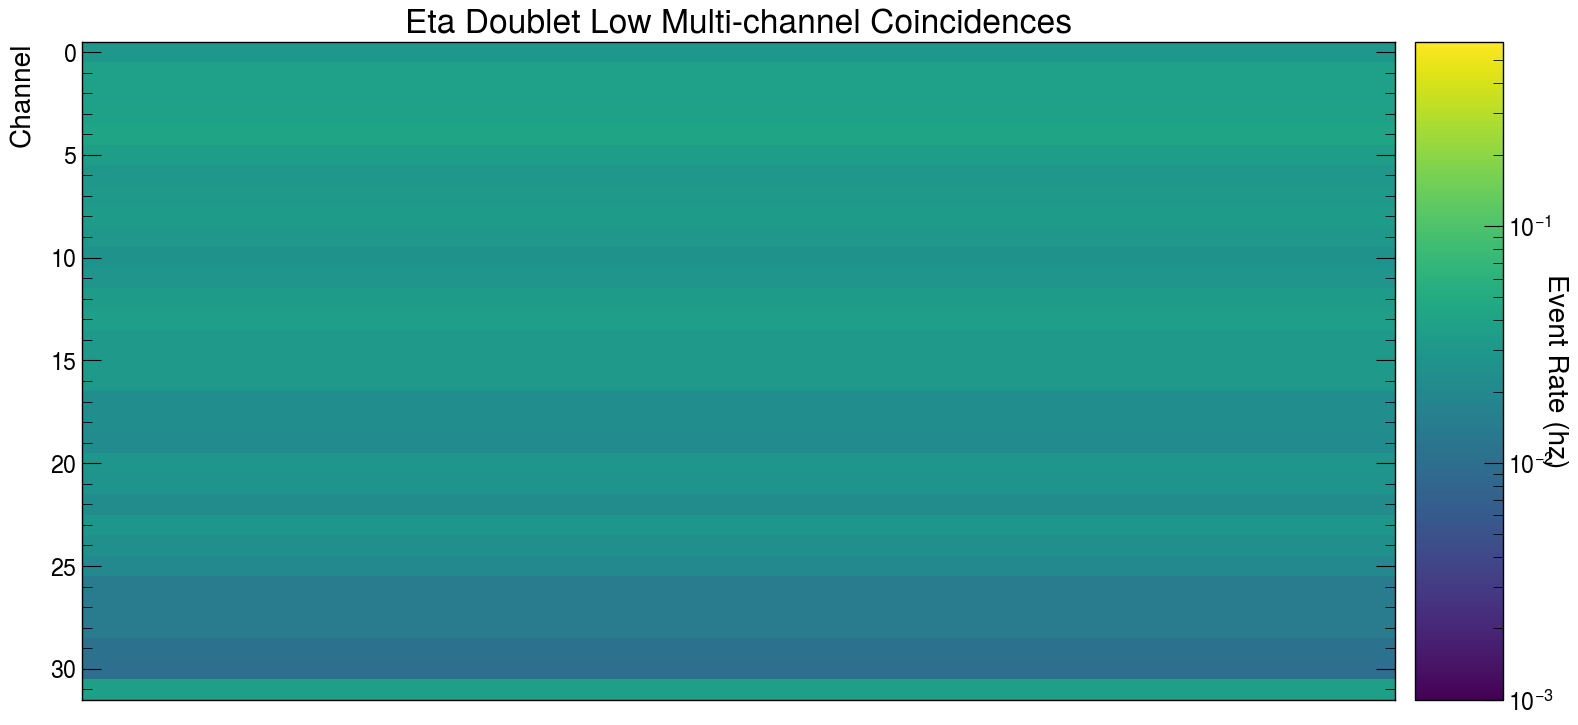

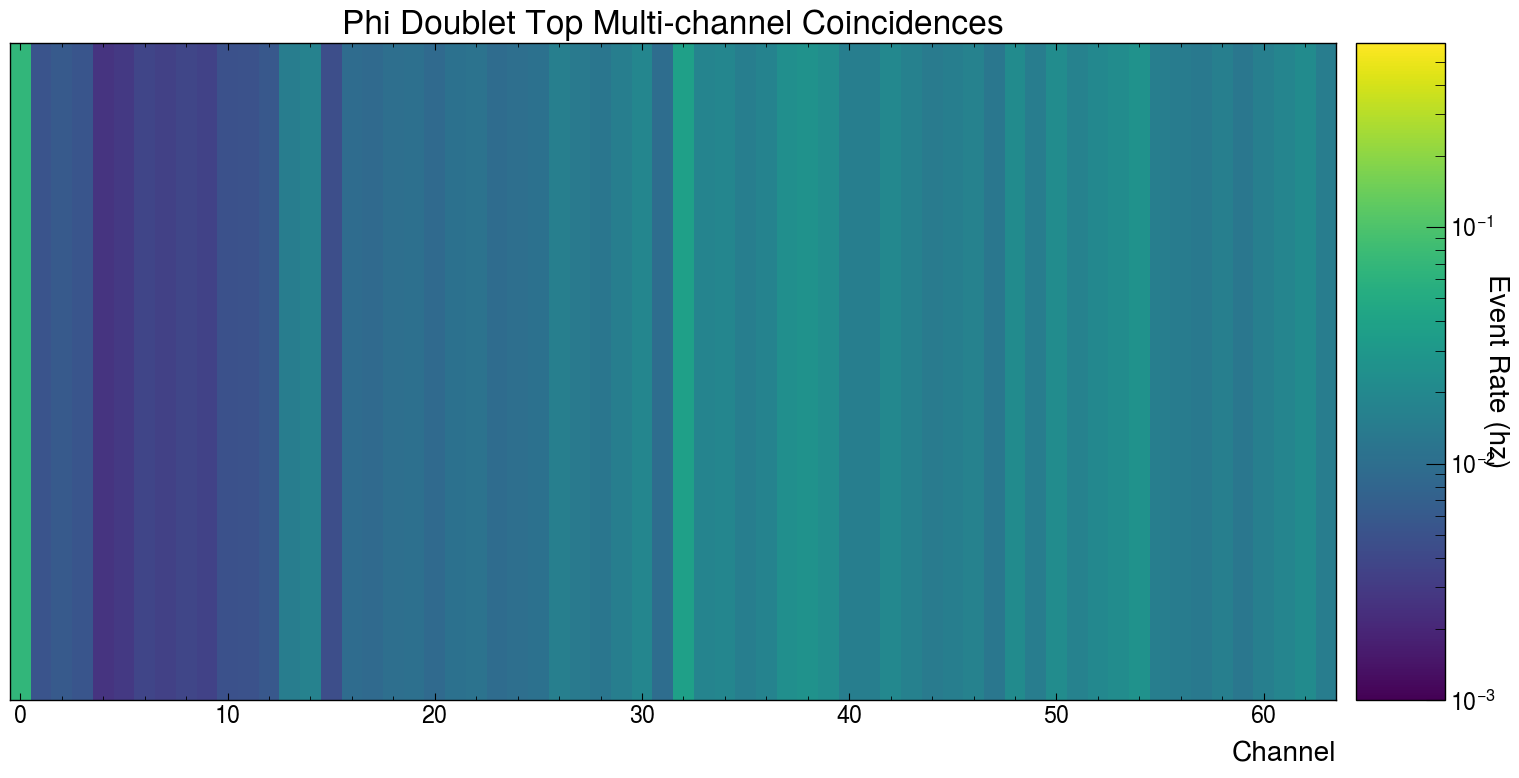

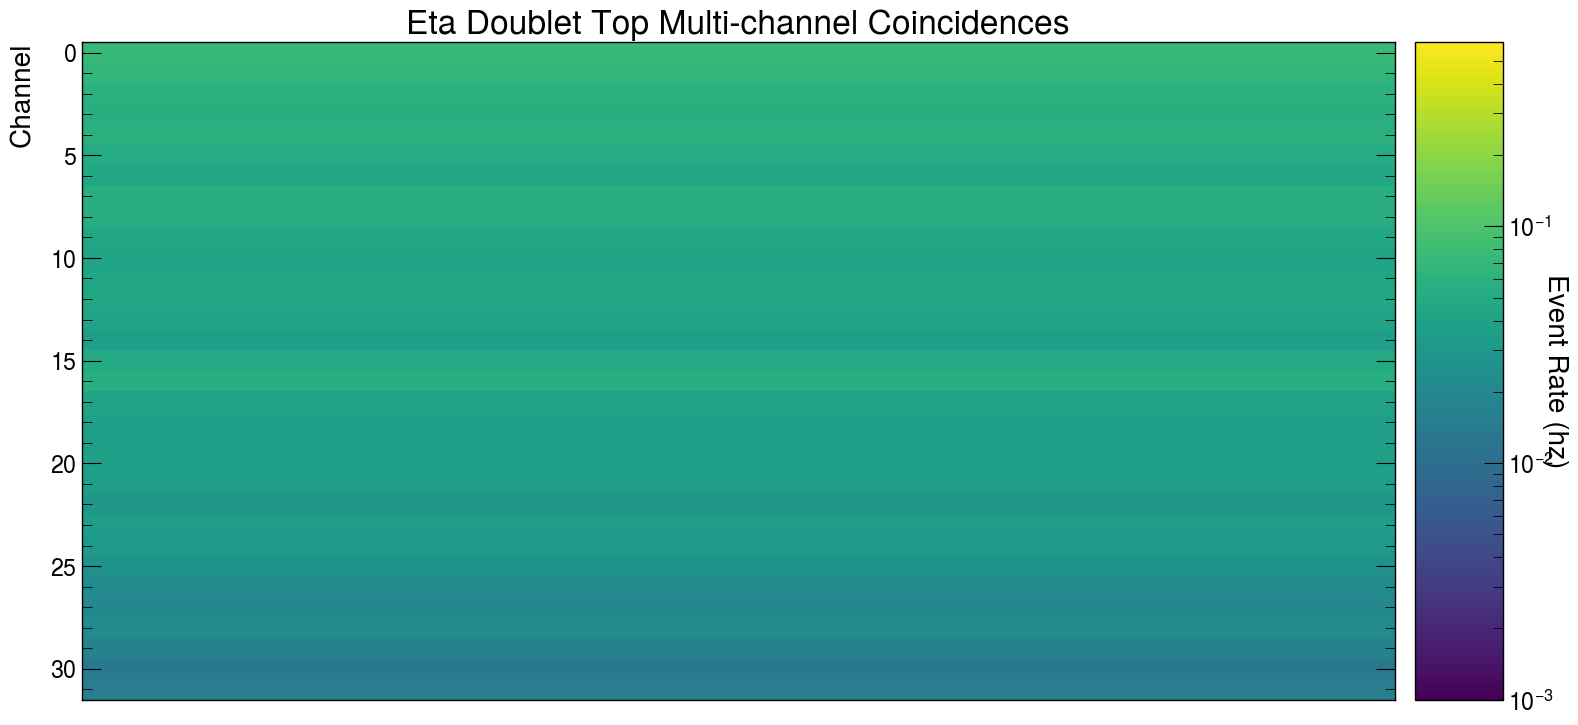

In [38]:
multCoincArray = []
thisRange = [0.001,0.6]
thisTime = 3600*3.
#Compare each eta/phi RPC to the nearest phi/eta rpc to plot immediate coincidences
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[0],etaHits[0]), "Phi Triplet Low Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[0],phiHits[0]), "Eta Triplet Low Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[1],etaHits[1]), "Phi Triplet Mid Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[1],phiHits[1]), "Eta Triplet Mid Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[2],etaHits[2]), "Phi Triplet Top Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[2],phiHits[2]), "Eta Triplet Top Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[3],etaHits[3]), "Phi Singlet Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[3],phiHits[3]), "Eta Singlet Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[4],etaHits[4]), "Phi Doublet Low Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[4],phiHits[4]), "Eta Doublet Low Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[5],etaHits[5]), "Phi Doublet Top Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[5],phiHits[5]), "Eta Doublet Top Multi-channel Coincidences", zrange = thisRange, unit='hz', time=thisTime))

anPlot.combinePlots(multCoincArray,"MultCoincMapsThreeHours")
for plot in multCoincArray:
    os.remove(plot)

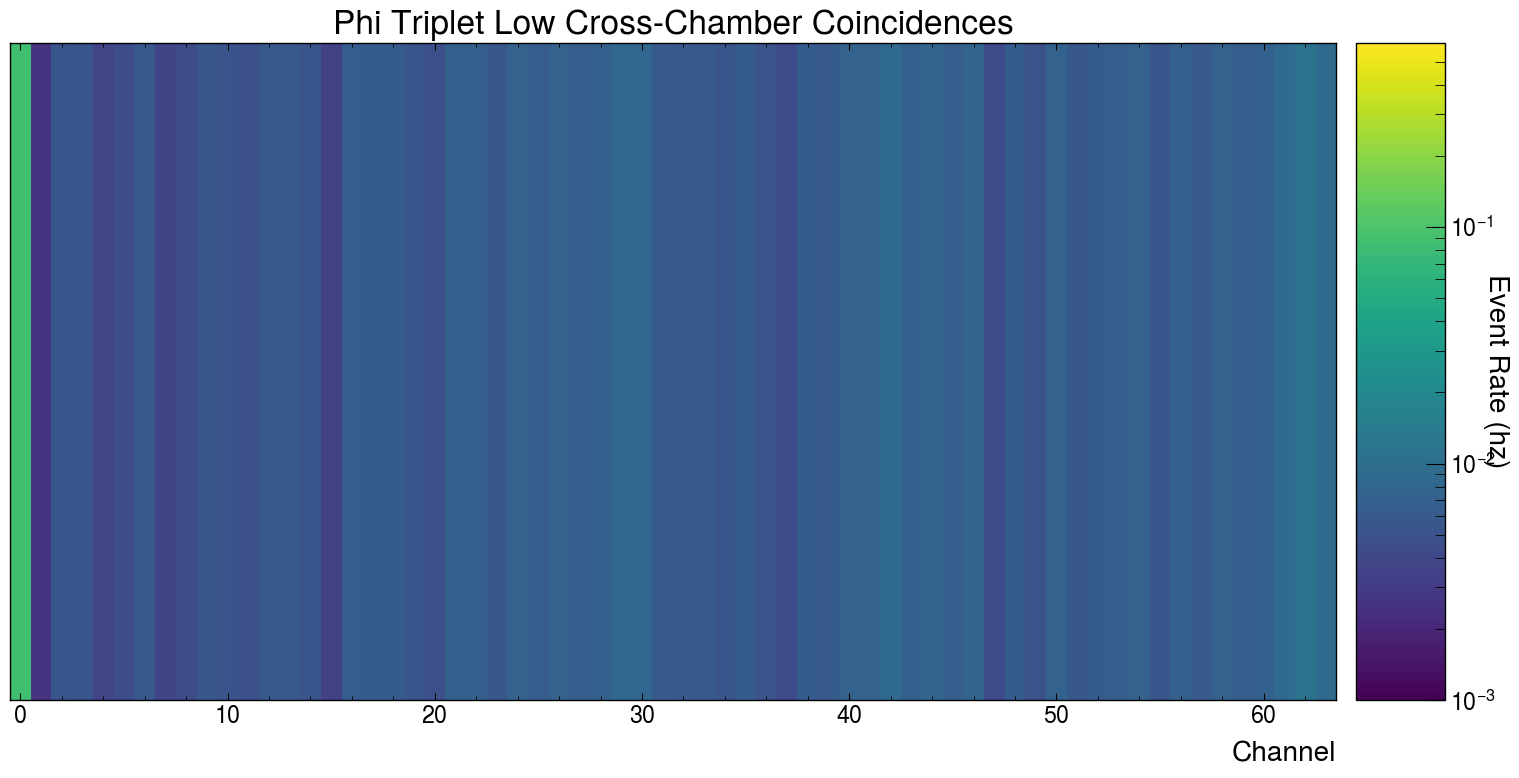

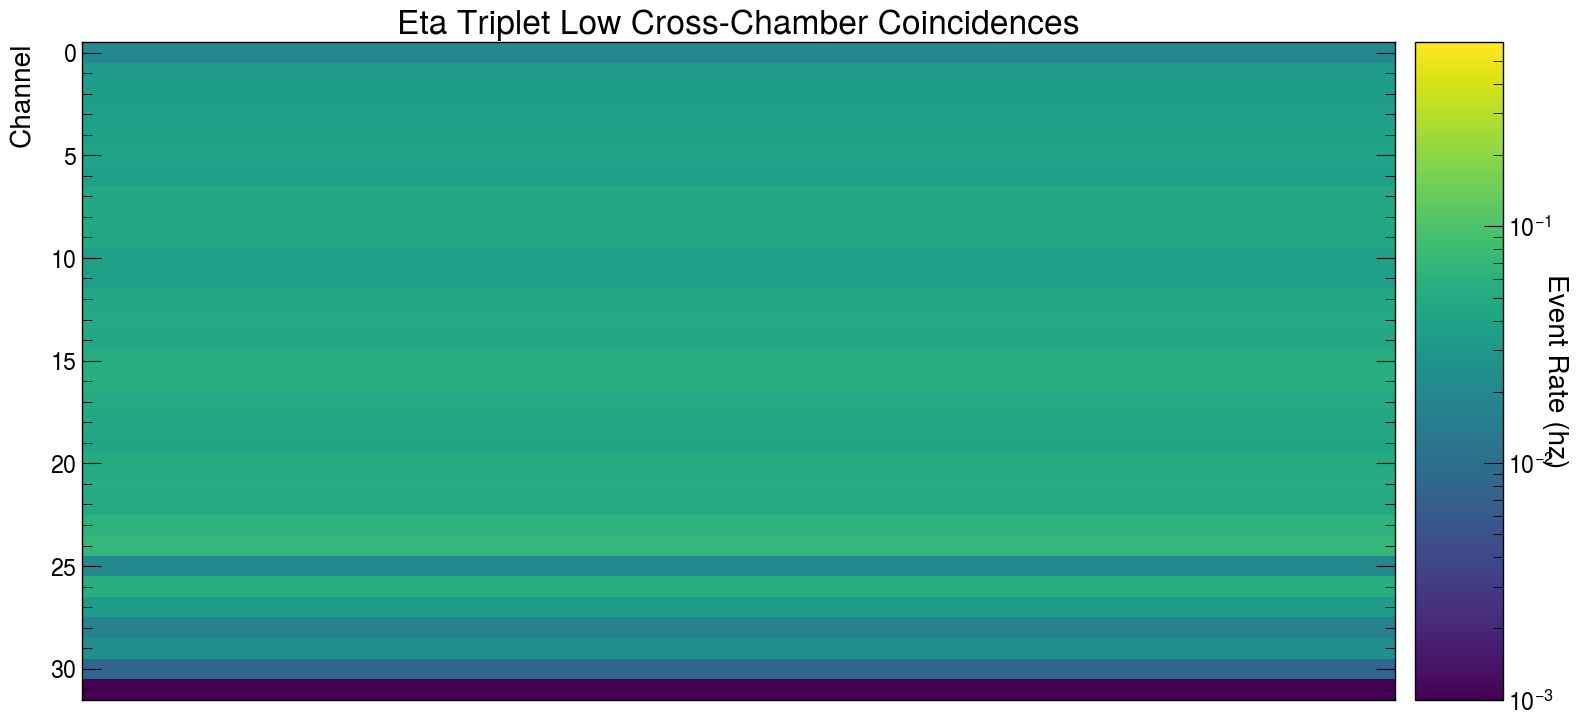

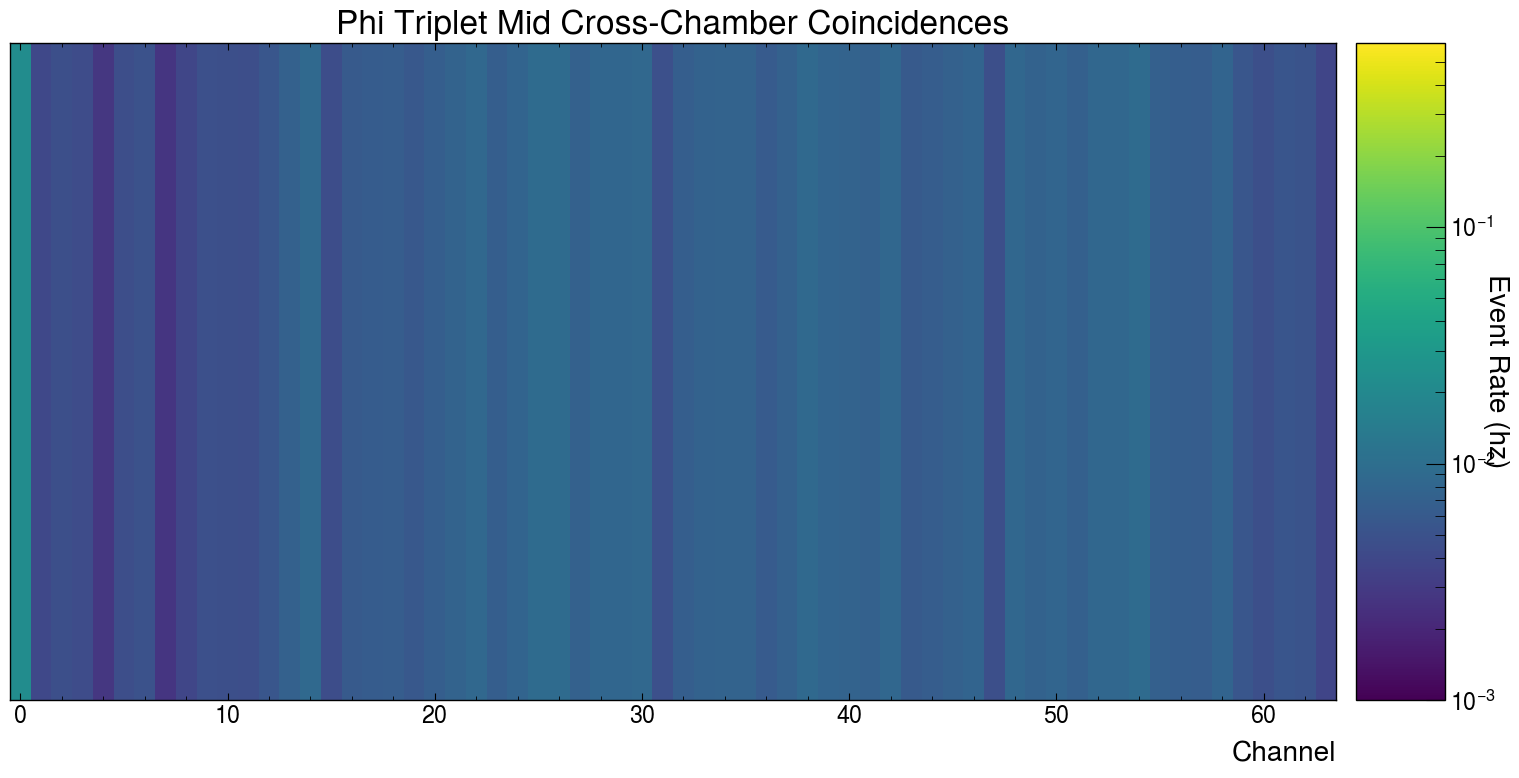

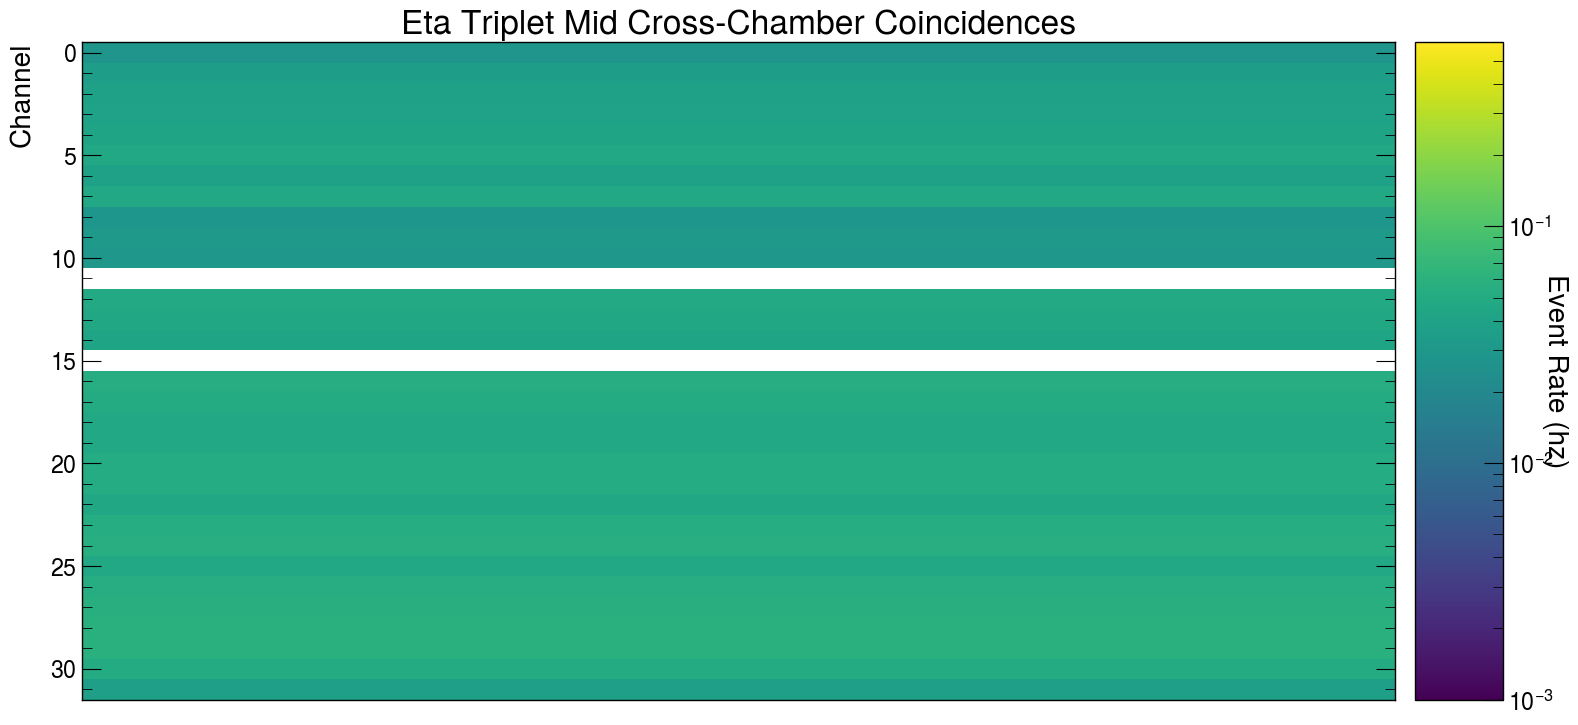

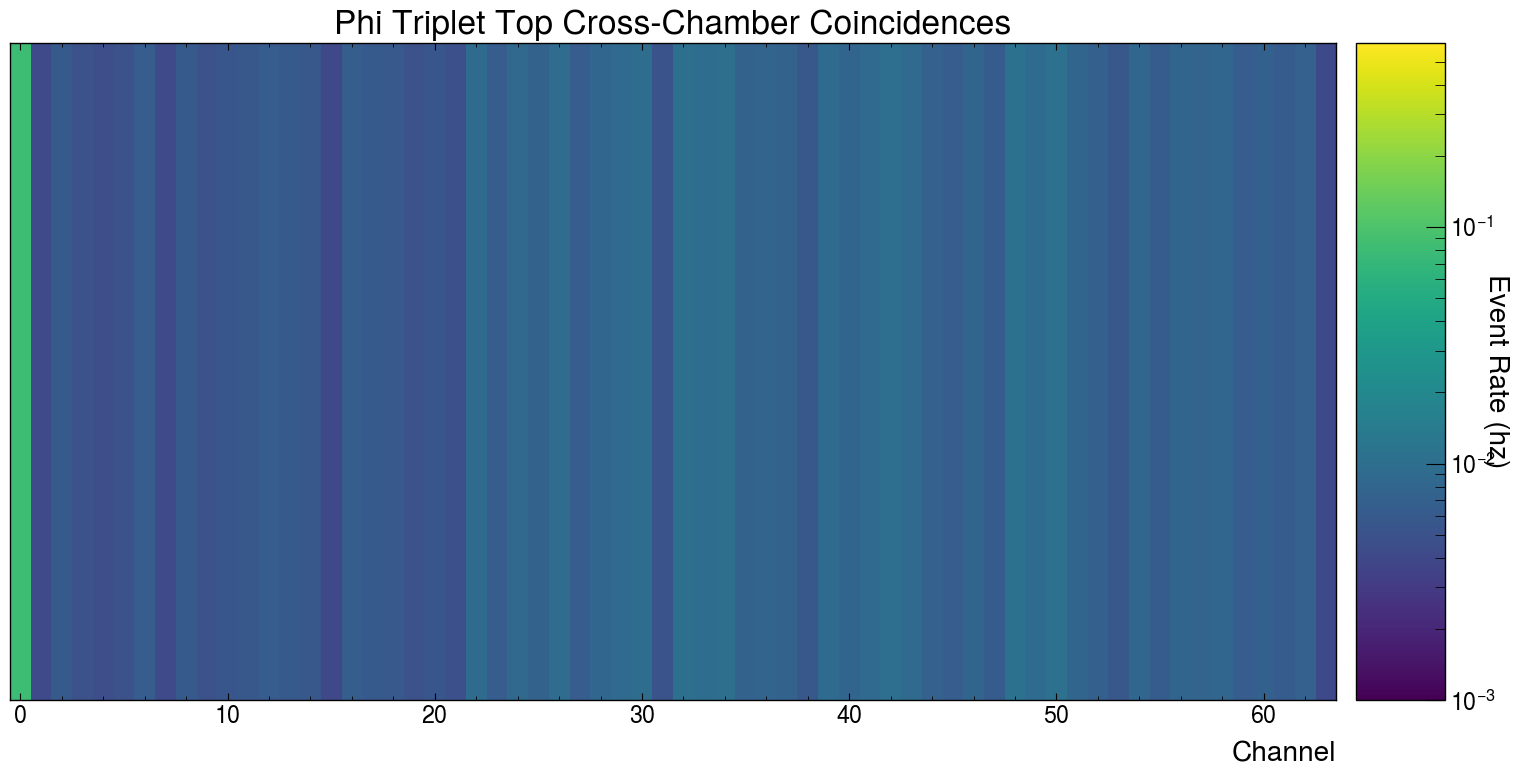

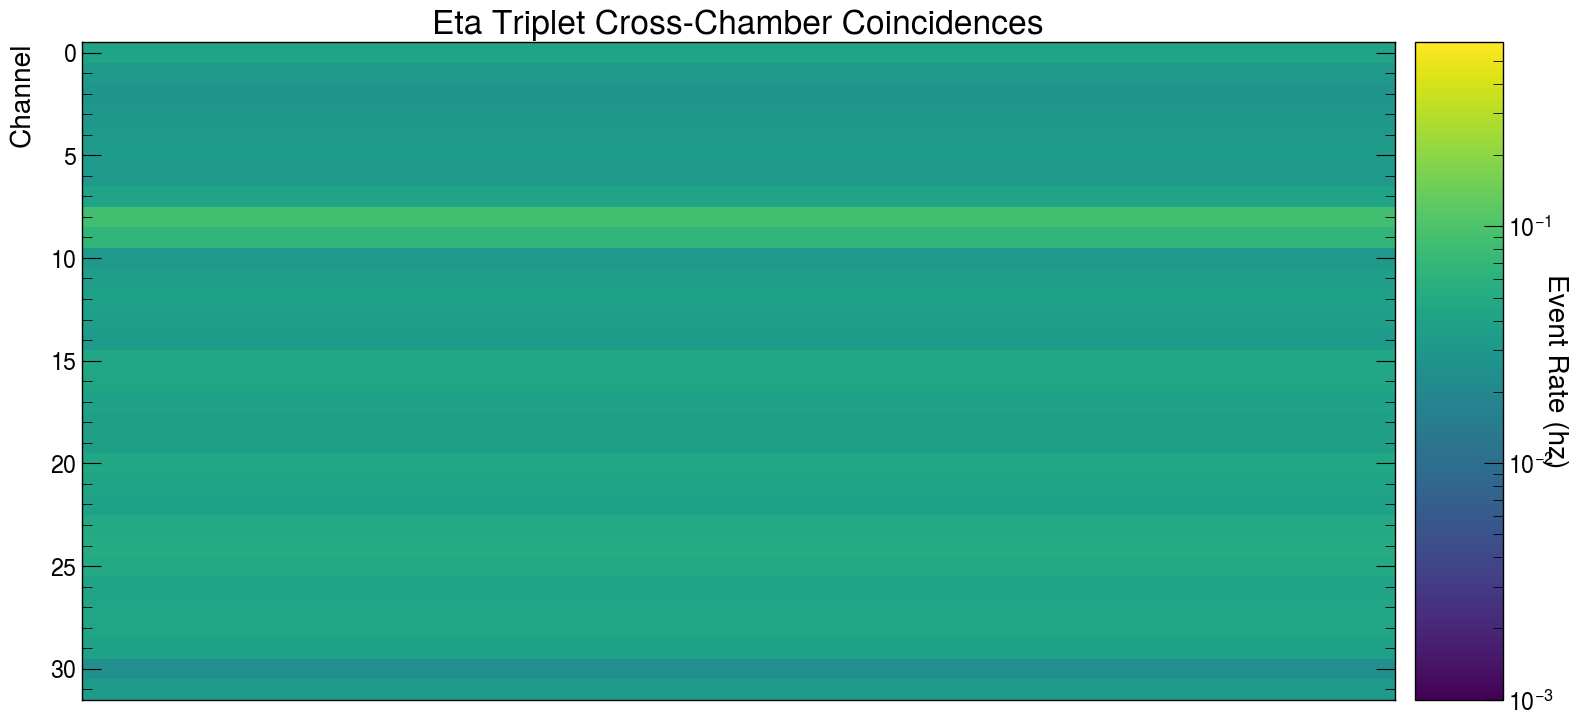

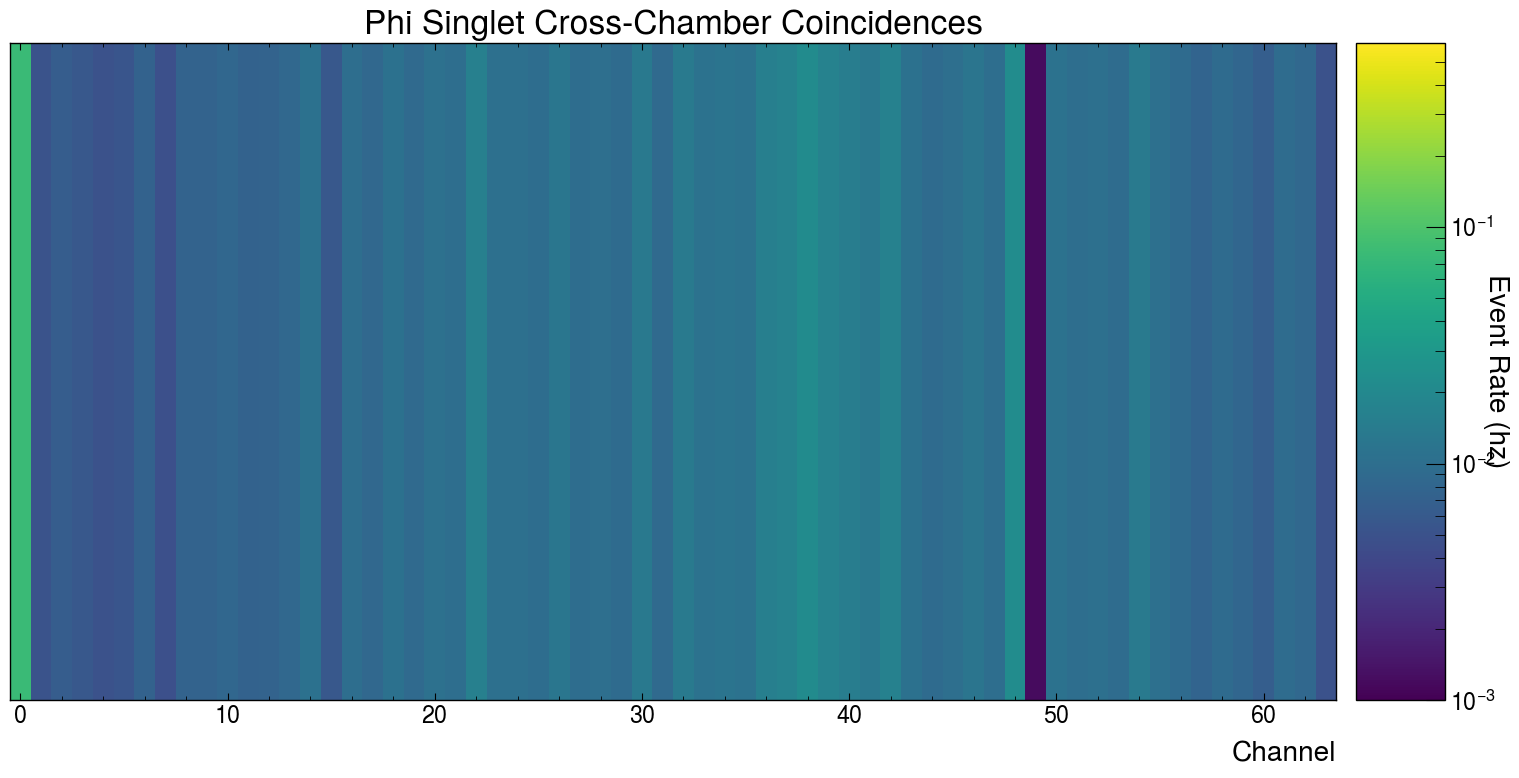

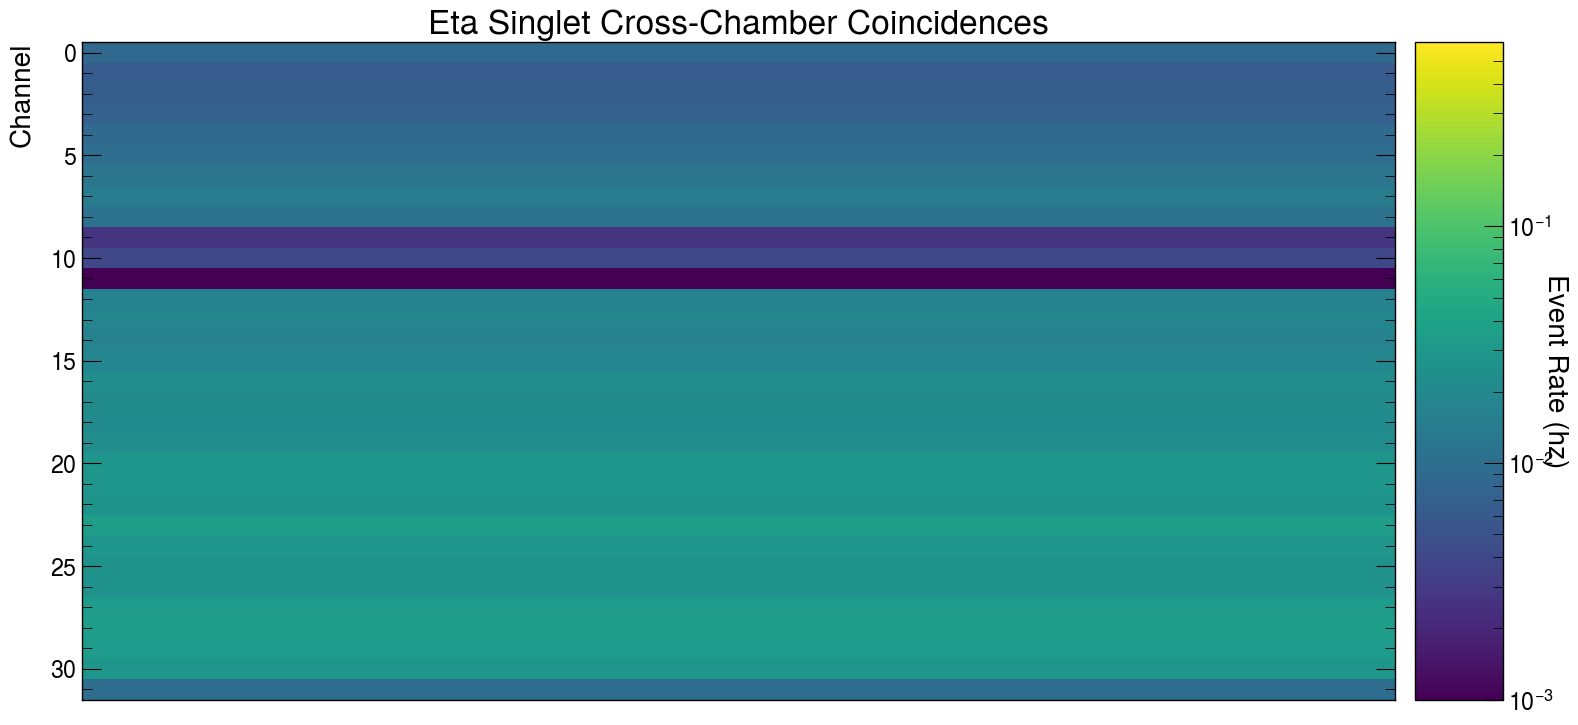

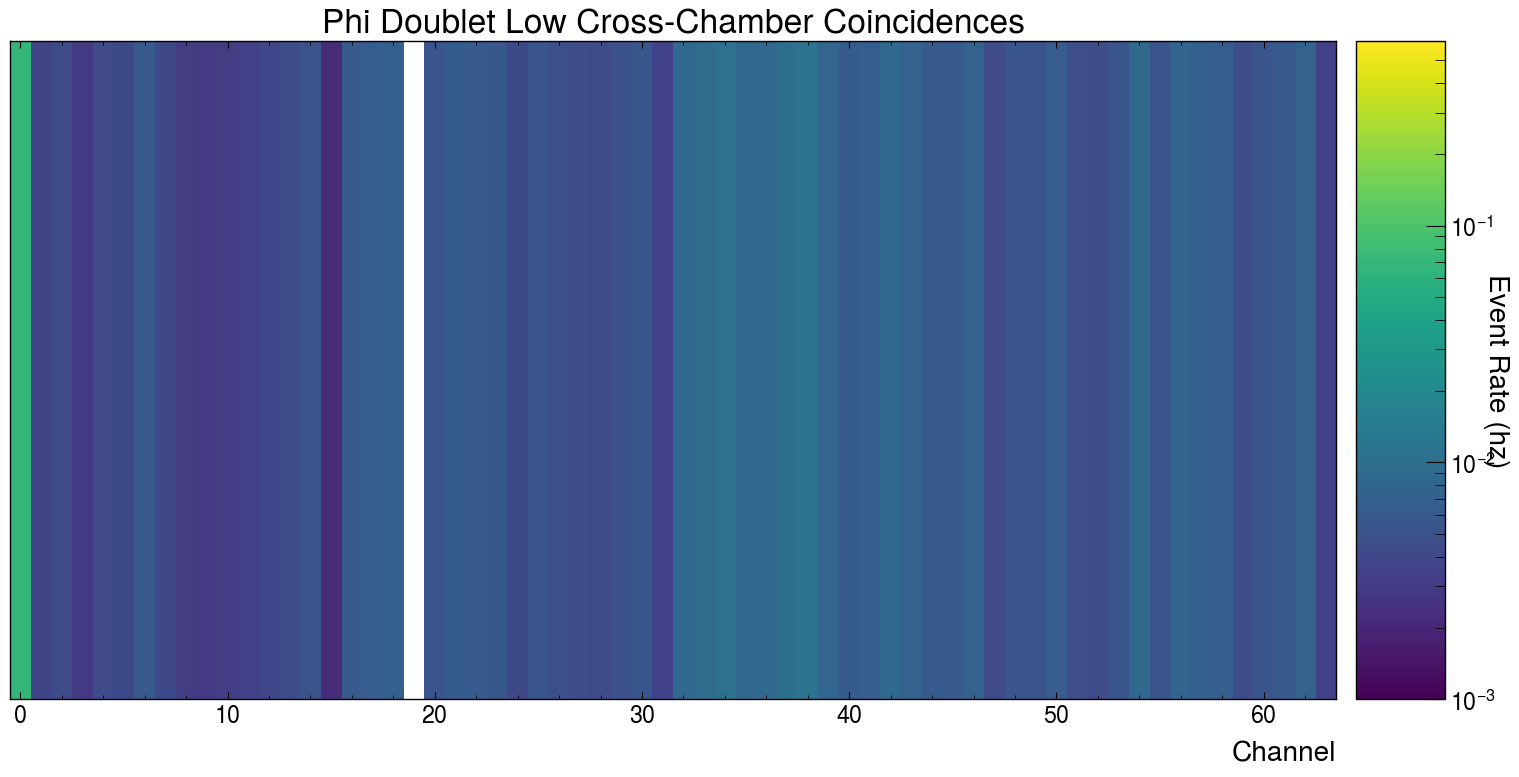

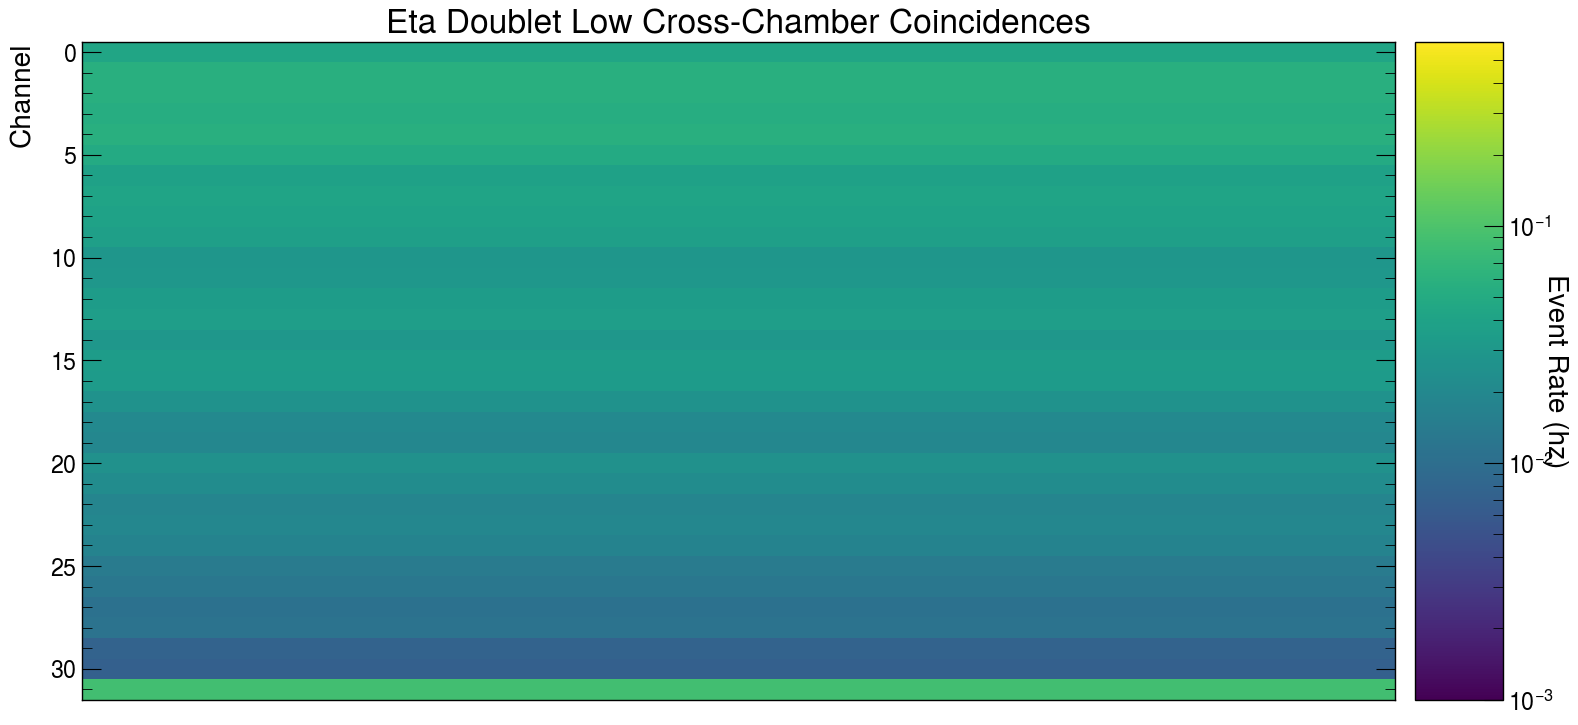

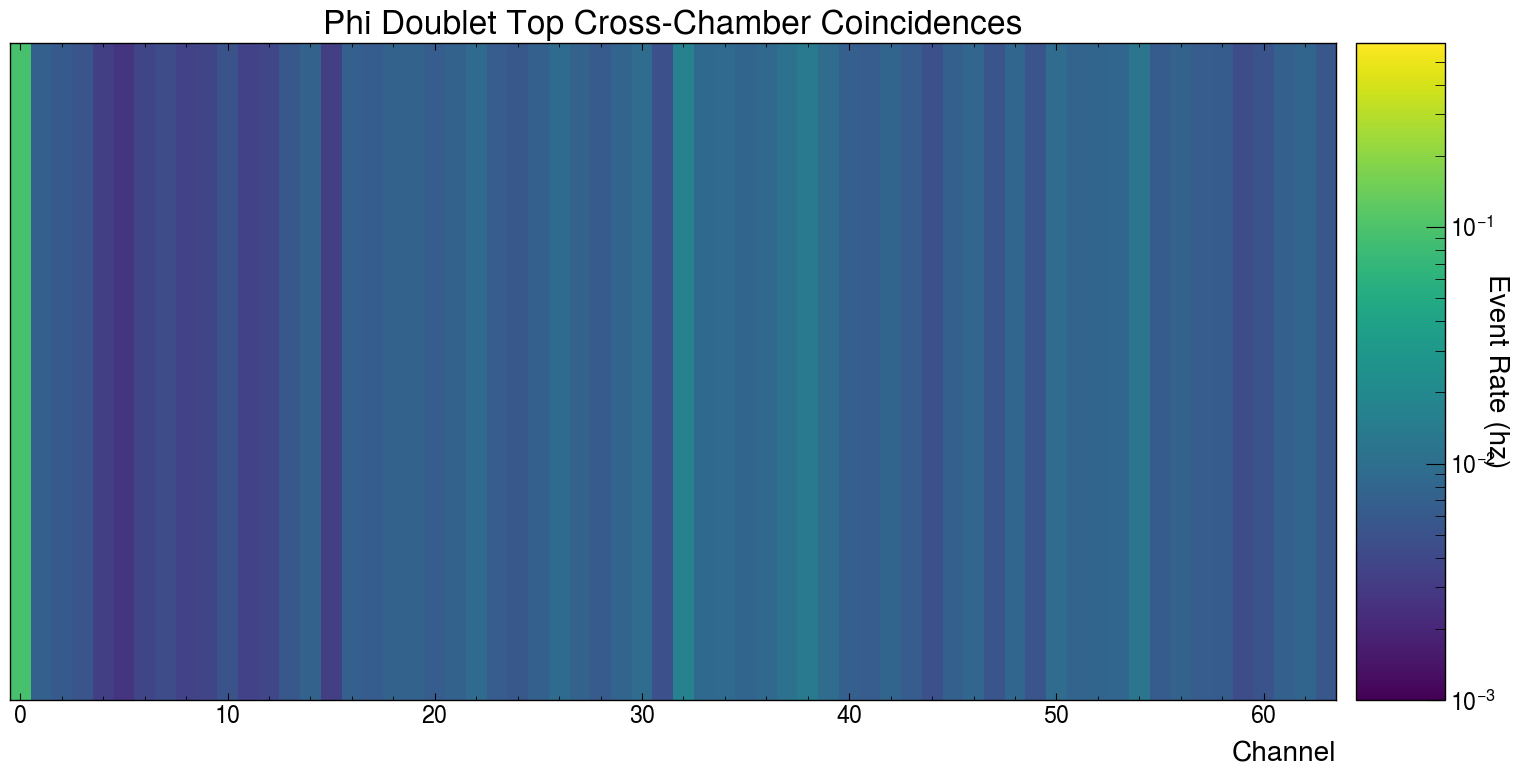

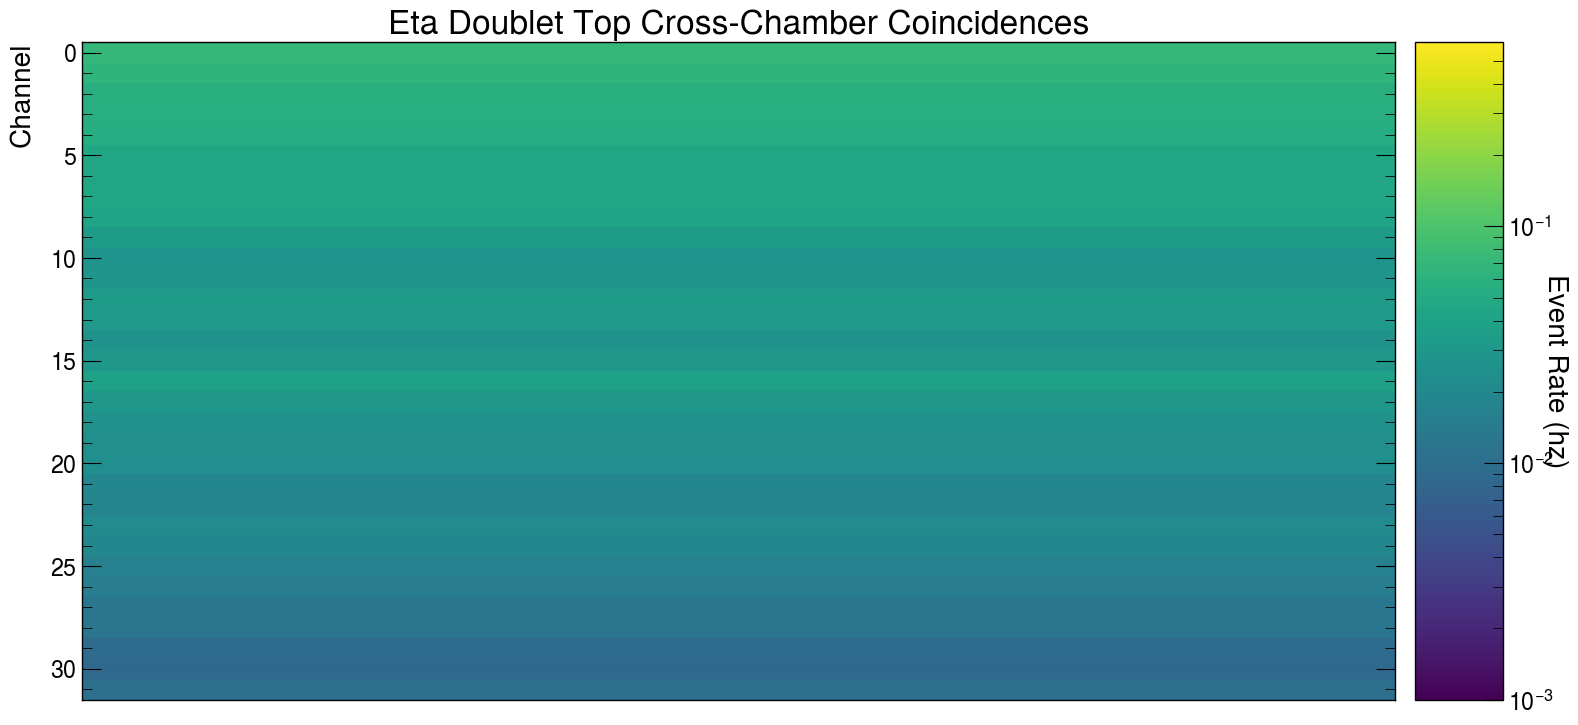

In [39]:
multCoincArray = []
thisRange = [0.001,0.6]
thisTime = 3600*3.
#Compare each eta/phi RPC to the nearest phi/eta RPC in a different chamber to find cross-chamber events and reduce the focus on triplet events
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[0],etaHits[3]), "Phi Triplet Low Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[0],phiHits[3]), "Eta Triplet Low Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[1],etaHits[3]), "Phi Triplet Mid Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[1],phiHits[3]), "Eta Triplet Mid Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[2],etaHits[3]), "Phi Triplet Top Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[2],phiHits[3]), "Eta Triplet Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[3],etaHits[4]), "Phi Singlet Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[3],phiHits[4]), "Eta Singlet Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[4],etaHits[3]), "Phi Doublet Low Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[4],phiHits[3]), "Eta Doublet Low Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotPhi(countCoincidences(phiHits[5],etaHits[3]), "Phi Doublet Top Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))
multCoincArray.append(anPlot.plotEta(countCoincidences(etaHits[5],phiHits[3]), "Eta Doublet Top Cross-Chamber Coincidences", zrange = thisRange, unit='hz', time=thisTime))

anPlot.combinePlots(multCoincArray,"CrossChamberMapsThreeHours")
for plot in multCoincArray:
    os.remove(plot)

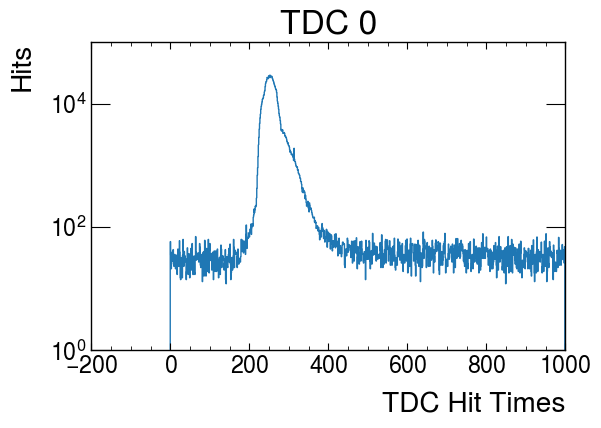

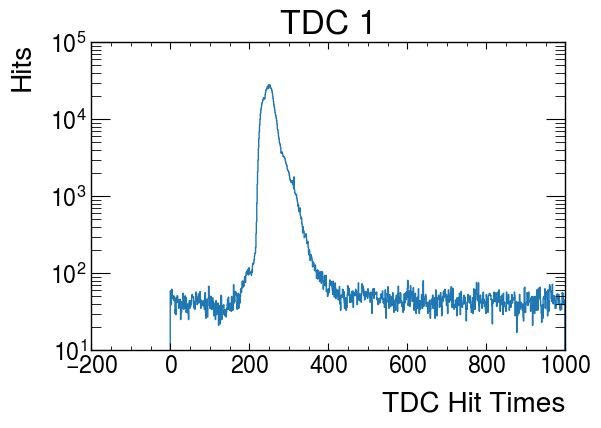

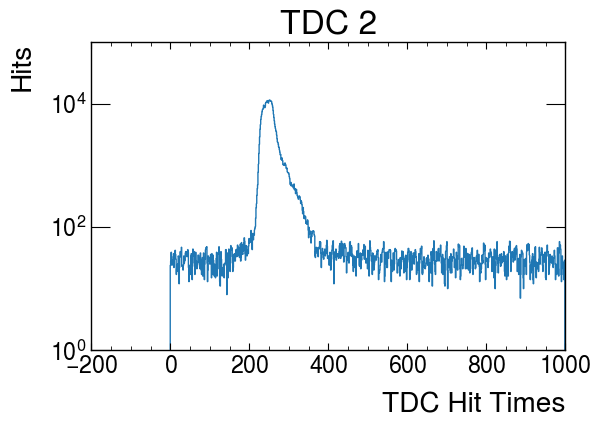

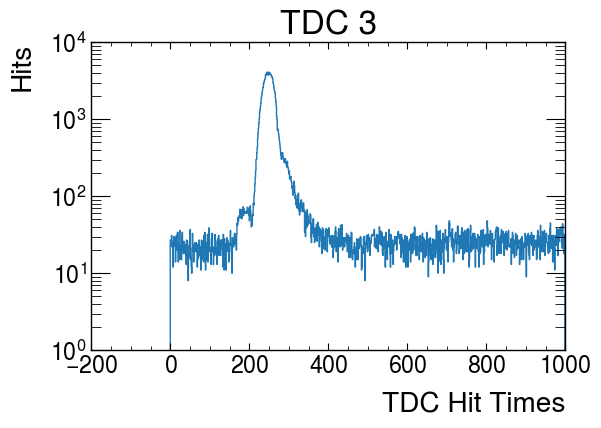

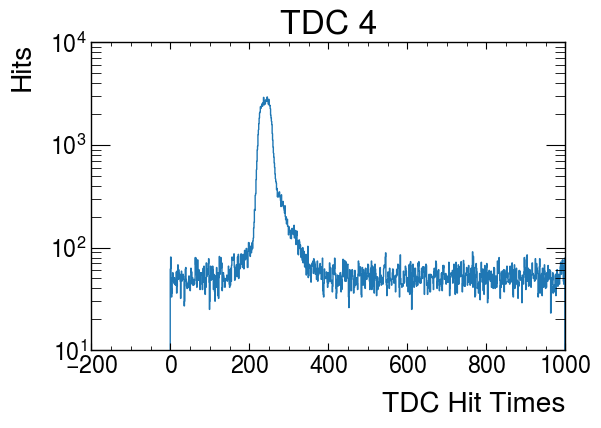

In [42]:
#Plot the event times split by TDC, useful for setting trigger window size and offset
tdcTimes = [[] for tdc in range(5)]
for tdc in range(5):
    tdcTimes[tdc] = tdcTimes[tdc] + getEventTimes(data[tdc])
timeMaps = []
for idx, tdcTime in enumerate(tdcTimes):
    timeMaps.append(plotEventTimes(tdcTime, "TDC "+str(idx)))
anPlot.combinePlots(timeMaps,"HitTimeArray")
for plot in timeMaps:
    os.remove(plot)

In [49]:
rpcSplitData = divideEventsByRPC(data)

92241
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


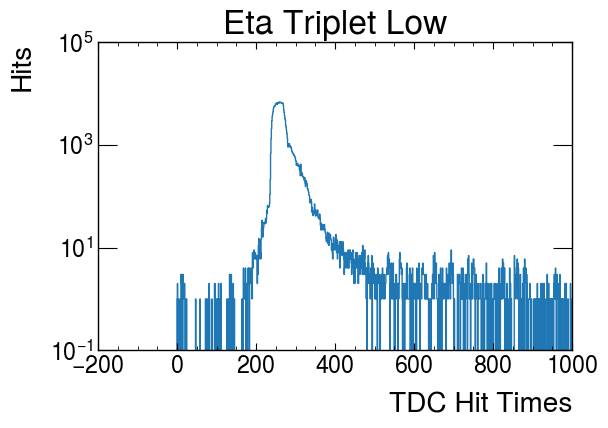

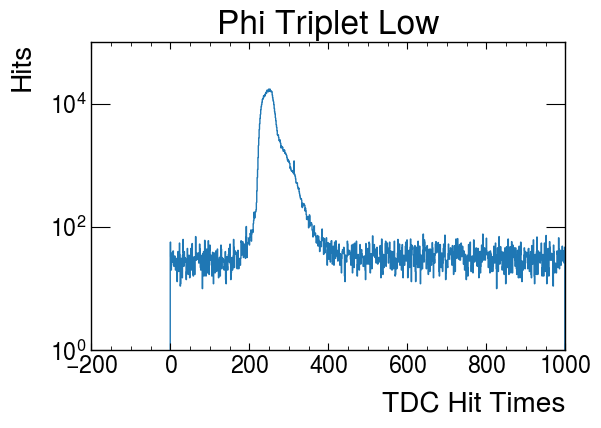

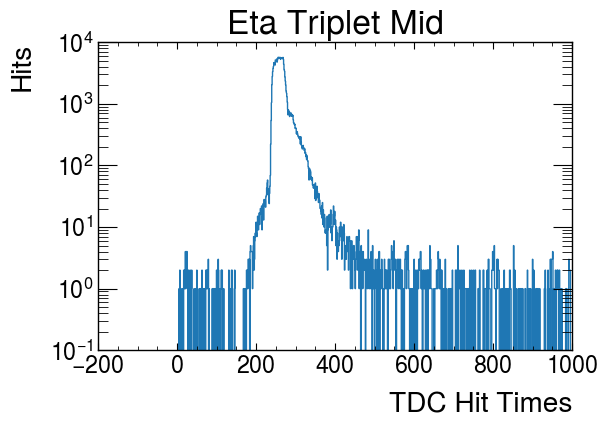

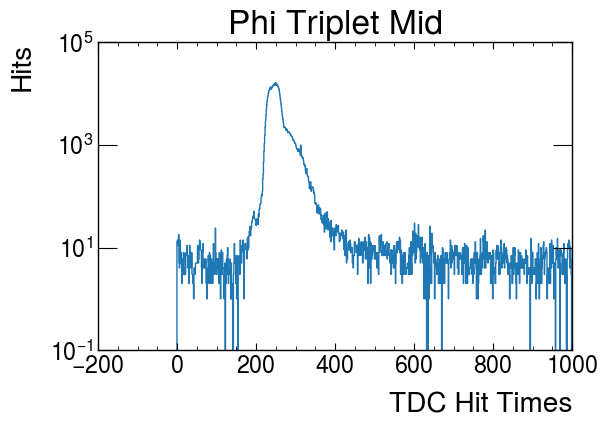

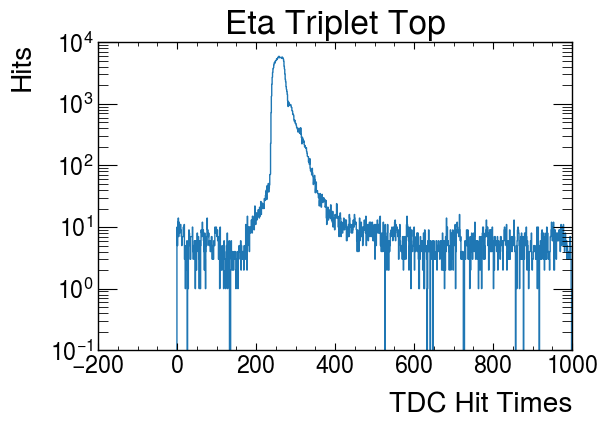

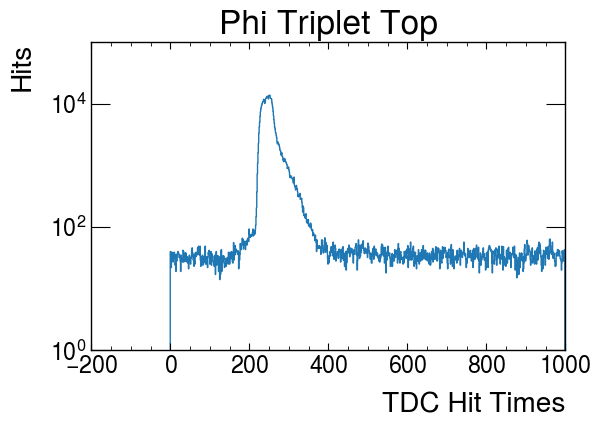

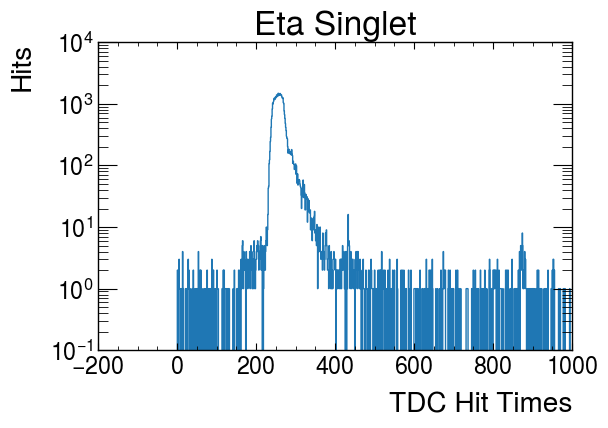

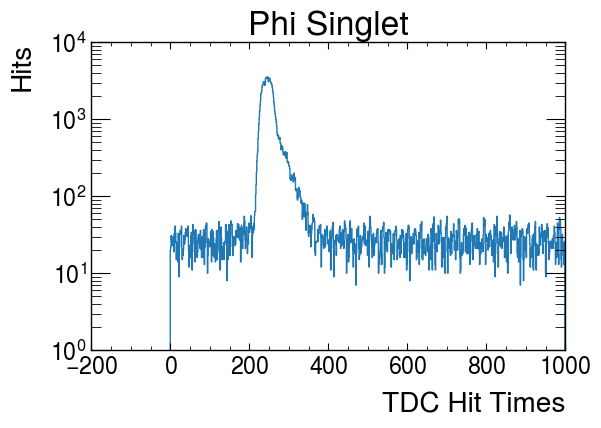

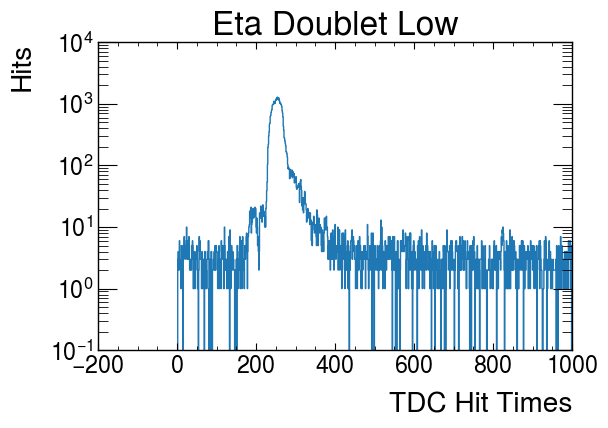

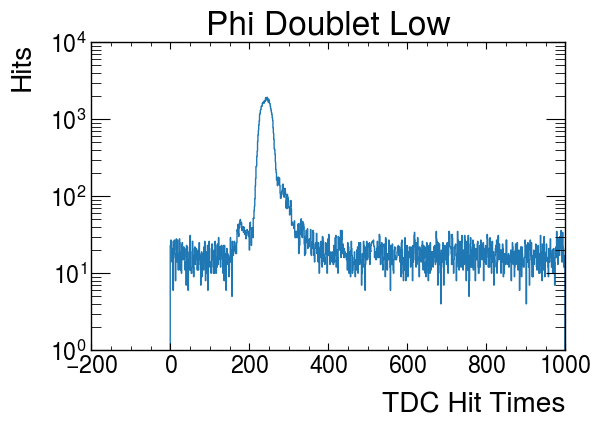

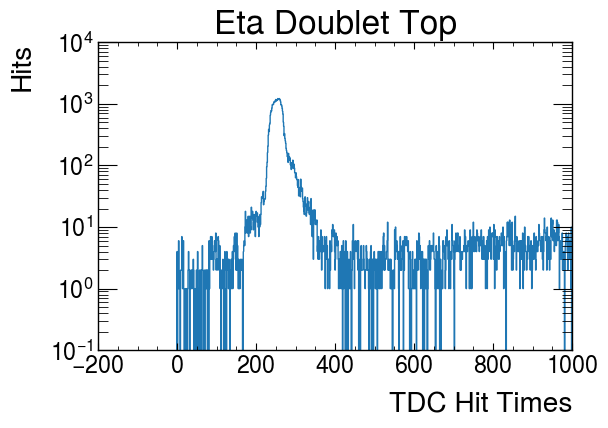

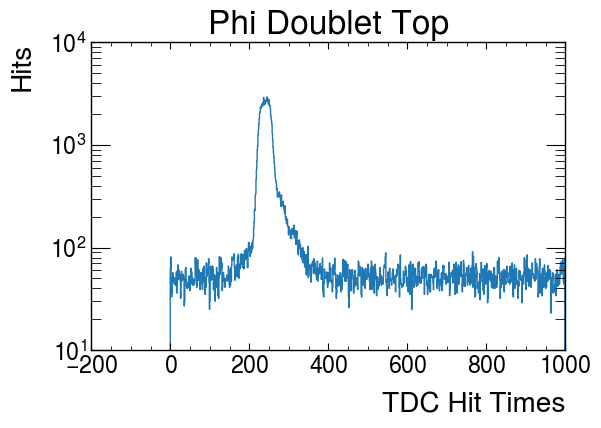

In [50]:
#Plot the hit times split by RPC, useful for characterizing each RPC and measuring noise

print(len(rpcSplitData))
i = 0
rpcNames = ['Eta Triplet Low',
            'Phi Triplet Low',
            'Eta Triplet Mid',
            'Phi Triplet Mid',
            'Eta Triplet Top',
            'Phi Triplet Top',
            'Eta Singlet',
            'Phi Singlet',
            'Eta Doublet Low',
            'Phi Doublet Low',
            'Eta Doublet Top',
            'Phi Doublet Top']
rpcHits = [[] for rpc in range(12)]
for event in rpcSplitData:
    print(i)
    i+=1
    for rpc in range(12):
        rpcHits[rpc] = rpcHits[rpc] + getEventTimes([event[rpc]])
rpcTimeMaps = []
for idx, tdcTime in enumerate(rpcHits):
    rpcTimeMaps.append(plotEventTimes(tdcTime,rpcNames[idx]))
anPlot.combinePlots(rpcTimeMaps,"RpcHitTimeArray")
for plot in rpcTimeMaps:
    os.remove(plot)

In [ ]:
bigFile = open("/eos/user/m/mireveri/anubis/dataFiles/trigRun24HourTest.txt")

thisEvent = []
data = [[] for tdc in range(5)]
tdc=0
prevTdcMax = 0
evtNum=0
lastTdc=-1
for idx, line in enumerate(bigFile):
    if "Header" in line:
        thisEvent = []
        splitline = line.split(" ")
        tdc = int(splitline[1].strip(","))
        if tdc is not lastTdc:
            if evtNum<prevTdcMax:
                print("Missing event, number is: "+str(evtNum),str(prevTdcMax),str(idx))
                break
            lastTdc=tdc
        evtNum = int(splitline[-1].strip("\n").strip(";"))
        if evtNum>prevTdcMax or evtNum==0:
            prevTdcMax=evtNum
    elif "Data" in line:
        thisEvent.append(int("0x"+line.split(" ")[2].strip("."),0))
    elif "EOB" in line:
        data[tdc].append(thisEvent)

In [ ]:
bigFile = open("/eos/user/m/mireveri/anubis/dataFiles/trigRun24HourTest.txt")
for idx, line in enumerate(bigFile):
    if idx>(33567604-100) and idx<(33567604):
        print(line.strip("\n"))

In [ ]:
heatFromFile('/eos/user/m/mireveri/anubis/dataFiles/trigRun24HourTest.txt',3600*24,"24 Hour Run")